In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import csv
import sys
import os
import h5py
import copy
import time
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [2]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
# !unzip -q PAMAP2_Dataset.zip

### Preprocessing Script

In [2]:
class data_reader:
    def __init__(self, train_test_files, use_columns, output_file_name):
        self.data, self.idToLabel = self.readPamap2(train_test_files, use_columns)
        self.save_data(output_file_name)

    def save_data(self, output_file_name):
        f = h5py.File(output_file_name)
        for key in self.data:
            f.create_group(key)
            for field in self.data[key]:
                f[key].create_dataset(field, data=self.data[key][field])
        f.close()
        print('Done.')

    @property
    def train(self):
        return self.data['train']

    @property
    def test(self):
        return self.data['test']

    def readPamap2(self,train_test_files,use_columns):
        files = train_test_files
        label_map = [
            # (0, 'other'),
            (1, 'lying'),
            (2, 'sitting'),
            (3, 'standing'),
            (4, 'walking'),
            (5, 'running'),
            (6, 'cycling'),
            (7, 'Nordic walking'),
            (9, 'watching TV'),
            (10, 'computer work'),
            (11, 'car driving'),
            (12, 'ascending stairs'),
            (13, 'descending stairs'),
            (16, 'vacuum cleaning'),
            (17, 'ironing'),
            (18, 'folding laundry'),
            (19, 'house cleaning'),
            (20, 'playing soccer'),
            (24, 'rope jumping')
        ]
        labelToId = {str(x[0]): i for i, x in enumerate(label_map)}
        # print("label2id=",labelToId)
        idToLabel = [x[1] for x in label_map]
        # print("id2label=",idToLabel)
        cols = use_columns
        # print "cols",cols
        data = {dataset: self.readPamap2Files(files[dataset], cols, labelToId)
                for dataset in ('train', 'test', 'validation')}
        return data, idToLabel

    def readPamap2Files(self, filelist, cols, labelToId):
        data = []
        labels = []
        for i, filename in enumerate(filelist):
            print('Reading file %d of %d' % (i+1, len(filelist)))
            with open('../data/raw/PAMAP2_Dataset/Protocol/%s' % filename, 'r') as f:
                reader = csv.reader(f, delimiter=' ')
                for line in reader:
                    elem = []
                    #not including the non related activity
                    if line[1] == "0":
                        # print(line)
                        continue
                    # if line[10] == "0":
                    #     continue
                    for ind in cols:
                        elem.append(line[ind])
                    if sum([x == 'NaN' for x in elem]) < 9:
                        data.append([float(x) / 100 for x in elem[:-1]])
                        labels.append(labelToId[elem[0]])
                        if elem[0] == 1:
                            print(labelToId[elem[0]])
        
        return {'inputs': np.asarray(data), 'targets': np.asarray(labels, dtype=int)+1}


def read_dataset(train_test_files, use_columns, output_file_name):
    print('Reading pamap2')
    dr = data_reader(train_test_files, use_columns, output_file_name)

def preprocess(file='./tmp/pamap2_106.h5', downsample=False, print_debug = True):
    path = os.path.join(file)
    f = h5py.File(path, 'r')

    train_x = f.get('train').get('inputs')[()]
    train_y = f.get('train').get('targets')[()]

    val_x = f.get('validation').get('inputs')[()]
    val_y = f.get('validation').get('targets')[()]

    test_x = f.get('test').get('inputs')[()]
    test_y = f.get('test').get('targets')[()]

    if print_debug:
        print("x_train shape = ", train_x.shape)
        print("y_train shape =", train_y.shape)
        print("x_val shape = ", val_x.shape)
        print("y_val shape =", val_y.shape)
        print("x_test shape =" ,test_x.shape)
        print("y_test shape =",test_y.shape)

    if downsample:
        train_x = train_x[::3,:]
        train_y = train_y[::3]
        val_x = val_x[::3,:]
        val_y = val_y[::3]
        test_x = test_x[::3,:]
        test_y = test_y[::3]

    if print_debug:
        print("x_train shape = ", train_x.shape)
        print("y_train shape =", train_y.shape)
        print("x_val shape = ", val_x.shape)
        print("y_val shape =", val_y.shape)
        print("x_test shape =" ,test_x.shape)
        print("y_test shape =",test_y.shape)

    # replace nan with mean
    # train_x = np.where(np.isnan(train_x), np.ma.array(train_x, mask=np.isnan(train_x)).mean(axis=0), train_x)
    # val_x = np.where(np.isnan(val_x), np.ma.array(val_x, mask=np.isnan(val_x)).mean(axis=0), val_x)
    # test_x = np.where(np.isnan(test_x), np.ma.array(test_x, mask=np.isnan(test_x)).mean(axis=0), test_x)
    train_x = np.nan_to_num(train_x)
    val_x = np.nan_to_num(val_x)
    test_x = np.nan_to_num(test_x)

    return (train_x, train_y), (val_x, val_y), (test_x, test_y)

### Train-Test Split (Subjectwise)

In [3]:
train_test_files = {
            'train': ['subject101.dat', 'subject102.dat','subject103.dat','subject104.dat', 'subject107.dat', 'subject108.dat', 'subject109.dat'],
            'validation': ['subject105.dat'],
            'test': ['subject106.dat']
        }

# use_columns = [1, 4, 5, 6, 10, 11, 12, 21, 22, 23, 27, 28, 29, 38, 39, 40, 44, 45, 46] #2 is heart-rate
use_columns = [1, 4, 5, 6, 10, 11, 12,13, 14, 15, 21, 22, 23, 27, 28, 29,30,31,32, 38, 39, 40, 44, 45, 46,47,48,49]


output_file_name = './tmp/pamap2_106.h5'

read_dataset(train_test_files, use_columns, output_file_name)

(train_x, train_y), (val_x, val_y), (test_x, test_y) = preprocess(downsample=False)

Reading pamap2
Reading file 1 of 7
Reading file 2 of 7
Reading file 3 of 7
Reading file 4 of 7
Reading file 5 of 7
Reading file 6 of 7


KeyboardInterrupt: 

In [ ]:
pd.Series(train_y).value_counts().plot(kind='bar')

In [3]:
from sklearn import preprocessing

scl = preprocessing.StandardScaler()
train_x = scl.fit_transform(train_x)
val_x = scl.transform(val_x)
test_x = scl.transform(test_x)

NameError: name 'train_x' is not defined

### Window - session

In [20]:
SLIDING_WINDOW_LENGTH = 1500
SLIDING_WINDOW_STEP = 500

In [21]:
def create_windowed_dataset(X=None, y=None, window_size=32, stride = 16):
    segments = []
    labels = []

    seg_start= 0
    seg_end = window_size
    while seg_end <= len(X):
        if len(np.unique(y[seg_start:seg_end])) == 1: #valid-window
            segments.append(X[seg_start:seg_end])
            labels.append(y[seg_start]) # doesn't matter all same labels

            seg_start += stride
            seg_end = seg_start + window_size

        else: #mixed- discard last few samples, move start to the new activity
            current_label = y[seg_start]
            for i in range(seg_start, seg_end):
                if y[i] != current_label:
                    seg_start = i
                    seg_end = seg_start + window_size
                    break

    return np.asarray(segments).astype(np.float32), np.asarray(labels)

In [35]:
X_train, y_train = create_windowed_dataset(train_x, train_y, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
X_val, y_val = create_windowed_dataset(val_x, val_y, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
X_test, y_test = create_windowed_dataset(test_x, test_y, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)

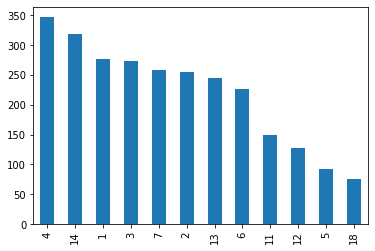

In [23]:
pd.Series(y_train).value_counts().plot(kind='bar')

In [1]:
labels_map = {1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'Nordic walking',
              11:'ascending stairs',12:'descending stairs',13:'vacuum cleaning',
              14:'ironing',18:'rope jumping'}
class_names = list(labels_map.values())

In [2]:
activity_map =labels_map

In [3]:
import json

with open("activities/pamap2_activity.json", "w") as outfile:  
    json.dump(activity_map, outfile, indent = 4) 

In [26]:
count = 1
prev = y_test[0]
for wndw in y_test:
    if wndw == prev:
        count+=1
    else:
        print(f'{prev} {activity_map[prev]} -  {count*SLIDING_WINDOW_LENGTH/100 - (count-1)*SLIDING_WINDOW_STEP/100} seconds')
        count=1
        prev=wndw
print(f'{prev} {activity_map[prev]} -  {count*SLIDING_WINDOW_LENGTH/100 - (count-1)*SLIDING_WINDOW_STEP/100} seconds')

1 lying -  455.0 seconds
2 sitting -  445.0 seconds
3 standing -  465.0 seconds
14 ironing -  735.0 seconds
13 vacuum cleaning -  405.0 seconds
11 ascending stairs -  105.0 seconds
12 descending stairs -  105.0 seconds
11 ascending stairs -  125.0 seconds
12 descending stairs -  85.0 seconds
4 walking -  495.0 seconds
7 Nordic walking -  515.0 seconds
6 cycling -  385.0 seconds
5 running -  435.0 seconds


In [29]:
np.unique(y_test, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7, 11, 12, 13, 14]),
 array([44, 44, 46, 49, 43, 38, 51, 22, 18, 40, 73]))

In [7]:
N_WINDOW = 15
N_TIMESTEP = 100

In [38]:
X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 18))
X_val = X_val.reshape((X_val.shape[0], N_WINDOW, N_TIMESTEP, 18))
X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 18))

le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=12)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=12)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=12)

In [39]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(2644, 15, 100, 18)
(2644, 12)
(510, 15, 100, 18)
(510, 12)
(468, 15, 100, 18)
(468, 12)


## Attention Model

In [4]:
class AggregateAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(AggregateAttention, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.d_model = d_model
        self.query = self.add_weight("learned_query",
                                     shape=[1, 1, self.d_model],
                                     initializer=tf.keras.initializers.Orthogonal())  
    
    def call(self, v, k):
        batched_query = tf.tile(self.query, [tf.shape(v)[0],1,1])
        output, attention_weights = self.mha(v, k, batched_query, mask=None)
        output = tf.squeeze(output, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=2)
        return output, attention_weights

### Self Attention

In [5]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model, include_dropout=True, dropout_rate=0.2):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.include_dropout = include_dropout
        if include_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, x):
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[:, :tf.shape(x)[1], :]
        if self.include_dropout:
            x = self.dropout(x)
        return x

In [6]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [7]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model,use_bias=True)
        self.wv = tf.keras.layers.Dense(d_model,use_bias=True)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [8]:
class SelfAttentionBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(SelfAttentionBlock, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [9]:
class CombinedSensorSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate, concat=True):
        super(CombinedSensorSelfAttention, self).__init__()
        self.concat = concat
        self.agr_attn = AggregateAttention(d_model, num_heads)
        self.ffn1 = point_wise_feed_forward_network(d_model, dff)
        self.ffn2 = point_wise_feed_forward_network(d_model, dff)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x):
        if self.concat:
            x = tf.concat(x, axis=1)
        x = self.ffn1(x)
        x, attn_score = self.agr_attn(x, x)
        x = self.dropout1(x)
        ffn_output = self.ffn2(x)  # (batch_size, d_model)
        ffn_output = self.dropout2(ffn_output)
        out = self.layernorm(ffn_output + x)  # (batch_size, d_model)
        return out, attn_score

In [10]:
class DataTransform(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super(DataTransform, self).__init__()
        # self.ln = tf.keras.layers.LayerNormalization()
        self.conv_1d = tf.keras.layers.Conv1D(d_model, 1, activation='relu')
    
    def call(self, x):
        # x = self.ln(x)
        x = self.conv_1d(x)
        return x

In [11]:
class ModalityEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_timesteps, d_model, num_heads, dff, num_sa_blocks=2, dropout_rate=0.1):
        super(ModalityEncoderBlock, self).__init__()
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.look_ahead_mask = create_look_ahead_mask(n_timesteps)
        self.data_transform = DataTransform(d_model)
        self.pe = PositionalEncoding(n_timesteps, d_model, dropout_rate=dropout_rate)
        self.num_sa_blocks = num_sa_blocks
        self.self_attn_blocks = [ SelfAttentionBlock(d_model, num_heads, dff, dropout_rate)
                                        for _ in range(self.num_sa_blocks)]
        # self.agr_attn = AttentionWithContext(return_attention=True)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = self.data_transform(x)
        x = self.pe(x)
        for i in range(self.num_sa_blocks):
            # x = self.self_attn_blocks[i](x, mask=self.look_ahead_mask)
            x = self.self_attn_blocks[i](x)
        return x


    def compute_output_shape(x, input_shape):
        return tf.TensorShape([input_shape[0], self.d_model])

In [12]:
def get_modality_encoder(modality_indices, n_timesteps, n_features,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    num_modality = len(modality_indices)-1
    inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
    attn_scores = []
    modality_outputs = []
    for i in range(num_modality):
            modality_x = inputs[:, :, modality_indices[i]:modality_indices[i+1] ]
            modality_x = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(modality_x)
            modality_outputs.append(modality_x)
    model = tf.keras.Model(inputs=inputs, outputs=modality_outputs)
    return model

In [13]:
class MultiWindowEncoder(tf.keras.layers.Layer):
    def __init__(self, modality_indices, n_window, n_timesteps, n_features, d_model, num_heads, dff, dropout_rate=0.1):
        super(MultiWindowEncoder, self).__init__()
        self.n_window = n_window
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.window_encoder = get_modality_encoder(modality_indices,n_timesteps=n_timesteps, n_features=n_features, d_model=d_model, num_heads = num_heads, dff=dff, dropout_rate=dropout_rate)
        self.combined_sensor_attn = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        feature_dim = tf.shape(x)[-1]
        x = tf.reshape(x, (-1, self.n_timesteps, feature_dim)) # all sessions in batch dim
        x = self.window_encoder(x)
        x, attn_scores = self.combined_sensor_attn(x)
        x = tf.reshape(x, (batch_size, -1, self.d_model))
        attn_scores = tf.reshape(attn_scores, (batch_size, -1, self.n_timesteps))
        return x, attn_scores

In [14]:
def get_modality_model_w_time_hierarchy(modality_indices,n_window, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=(n_window, n_timesteps,n_features,))
    x, _ = MultiWindowEncoder(modality_indices, n_window, n_timesteps,n_features, d_model, num_heads, dff, dropout_rate=0.1) (inputs)
    x = ModalityEncoderBlock(n_timesteps=n_window, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(x)
    x, _ = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate, concat=False) (x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

## Traiining

In [40]:
tf.keras.backend.clear_session()

n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
model = get_modality_model_w_time_hierarchy([0, 6, 12, 18], n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics='accuracy')
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 100, 18)]     0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 383808    
_________________________________________________________________
modality_encoder_block_3 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 82944     
_________________________________________________________________
dense_64 (Dense)             (None, 12)                780       
Total params: 571,532
Trainable params: 571,532
Non-trainable params: 0
_________________________________________________________________


In [41]:
verbose, epochs, batch_size = 1, 25, 64
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,verbose=1, mode='max')
#mcp_save = ModelCheckpoint('test_3_best.hdf5', save_best_only=True, monitor='val_acc', mode='max')
# reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
          verbose=verbose, validation_data=(X_val, y_val))

# model.fit(X_train, [y_train, X_train], epochs=epochs, batch_size=batch_size,
#               verbose=verbose, validation_data=(X_val, [y_val, X_val]))

Epoch 1/25
42/42 [==============================] - 11s 271ms/step - loss: 1.6546 - accuracy: 0.4660 - val_loss: 0.6449 - val_accuracy: 0.7608
Epoch 2/25
42/42 [==============================] - 9s 223ms/step - loss: 0.3381 - accuracy: 0.9028 - val_loss: 0.3060 - val_accuracy: 0.9059
Epoch 3/25
42/42 [==============================] - 9s 224ms/step - loss: 0.1465 - accuracy: 0.9592 - val_loss: 0.1444 - val_accuracy: 0.9549
Epoch 4/25
42/42 [==============================] - 9s 224ms/step - loss: 0.1312 - accuracy: 0.9667 - val_loss: 0.1299 - val_accuracy: 0.9627
Epoch 5/25
42/42 [==============================] - 9s 224ms/step - loss: 0.1085 - accuracy: 0.9697 - val_loss: 0.6244 - val_accuracy: 0.8549
Epoch 6/25
42/42 [==============================] - 9s 225ms/step - loss: 0.1272 - accuracy: 0.9607 - val_loss: 0.3581 - val_accuracy: 0.8980
Epoch 7/25
42/42 [==============================] - 9s 226ms/step - loss: 0.1467 - accuracy: 0.9618 - val_loss: 1.2176 - val_accuracy: 0.8294
Epoch

In [43]:
# pred, recon = model.predict(X_test, batch_size=64)
pred = model.predict(X_test, batch_size=64)

In [44]:
np.unique(np.argmax(pred, axis=1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([53, 44, 35, 51, 43, 38, 51, 22, 19, 39, 73]))

In [45]:
np.unique(np.argmax(y_test, axis=1), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([44, 44, 46, 49, 43, 38, 51, 22, 18, 40, 73]))

In [46]:
print(metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        44
           1       0.77      0.77      0.77        44
           2       0.97      0.74      0.84        46
           3       0.96      1.00      0.98        49
           4       1.00      1.00      1.00        43
           5       1.00      1.00      1.00        38
           6       1.00      1.00      1.00        51
           7       1.00      1.00      1.00        22
           8       0.95      1.00      0.97        18
           9       1.00      0.97      0.99        40
          10       1.00      1.00      1.00        73

    accuracy                           0.95       468
   macro avg       0.95      0.95      0.95       468
weighted avg       0.95      0.95      0.95       468



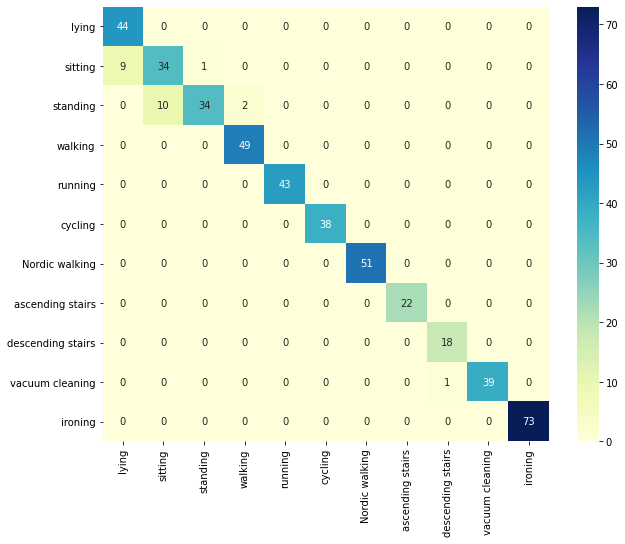

In [50]:
confm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
# activity_list = hi_idToLabel[1:]
df_cm = pd.DataFrame(confm, index=class_names[:-1], columns=class_names[:-1])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

## LOSO

In [33]:
labels_map = {1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'Nordic walking',
              11:'ascending stairs',12:'descending stairs',13:'vacuum cleaning',
              14:'ironing', 18:'rope jumping'}
class_names = list(labels_map.values())

def run_experiment():
    for i in range(1,10):
        train = set([f'subject10{sub}.dat' for sub in range(1,10)])
        test = set([f'subject10{i}.dat'])
        train = train -test
        train_test_files = {
                'train': list(train),
                'test': list(test),
                'validation': []
        }
        print('test sub', train_test_files['test'])
        print(train_test_files)

        # use_columns = [1, 4, 5, 6, 10, 11, 12, 21, 22, 23, 27, 28, 29, 38, 39, 40, 44, 45, 46] #2 is heart-rate
        use_columns = [1, 4, 5, 6, 10, 11, 12,13, 14, 15, 21, 22, 23, 27, 28, 29,30,31,32, 38, 39, 40, 44, 45, 46,47,48,49]

        output_file_name = f'pamap2_10{i}.h5'

        read_dataset(train_test_files, use_columns, output_file_name)

        (train_x, train_y), (val_x, val_y), (test_x, test_y) = preprocess(output_file_name, downsample=False, print_debug = False)

        scl = preprocessing.StandardScaler()
        train_x = scl.fit_transform(train_x)
        # val_x = scl.transform(val_x)
        test_x = scl.transform(test_x)

        SLIDING_WINDOW_LENGTH = 1500
        SLIDING_WINDOW_STEP = 500

        X_train, y_train = create_windowed_dataset(train_x, train_y, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
        # X_val, y_val = create_windowed_dataset(val_x, val_y, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)
        X_test, y_test = create_windowed_dataset(test_x, test_y, window_size=SLIDING_WINDOW_LENGTH, stride = SLIDING_WINDOW_STEP)

        N_WINDOW = 15
        N_TIMESTEP = 100

        X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, 27))
        # X_val = X_val.reshape((X_val.shape[0], N_WINDOW, N_TIMESTEP, 18))
        X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, 27))

        y_train = tf.keras.utils.to_categorical(y_train, num_classes=19)
        # y_val = tf.keras.utils.to_categorical(y_val, num_classes=12)
        y_test = tf.keras.utils.to_categorical(y_test, num_classes=19)

        tf.keras.backend.clear_session()

        n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
        model = get_modality_model_w_time_hierarchy([0, 9, 18, 27], n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics='accuracy')
        # model.summary()

        verbose, epochs, batch_size = 2, 40, 64

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        
        pred = model.predict(X_test, batch_size=64)
            
        print(metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1),labels = list(labels_map.keys()), target_names=class_names, zero_division=1))
        out_res = open(os.path.join('result/pamap2', str('rm2_subject' + str(i).zfill(2) + '.txt')), 'w')
        print(metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1),labels = list(labels_map.keys()), target_names=class_names, zero_division=1), file=out_res)
        
        confm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), labels = list(labels_map.keys()))
        df_cm = pd.DataFrame(confm, index=class_names, columns=class_names)
        plt.figure(figsize = (10,8))
        sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
        out_fig = 'rm2_subject' + str(i).zfill(2) + '.png'
        plt.savefig(os.path.join('result/pamap2', out_fig))
        plt.show()

test sub ['subject101.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat'], 'test': ['subject101.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/30
50/50 - 7s - loss: 1.5686 - accuracy: 0.4643
Epoch 2/30
50/50 - 7s - loss: 0.4786 - accuracy: 0.8371
Epoch 3/30
50/50 - 7s - loss: 0.2273 - accuracy: 0.9296
Epoch 4/30
50/50 - 7s - loss: 0.1253 - accuracy: 0.9645
Epoch 5/30
50/50 - 7s - loss: 0.0796 - accuracy: 0.9791
Epoch 6/30
50/50 - 7s - loss: 0.0834 - accuracy: 0.9781
Epoch 7/30
50/50 - 7s - loss: 0.2474 - accuracy: 0.9290
Epoch 8/30
50/50 - 7s - loss: 0.1300 - accuracy: 0.9597
Epoch 9/30
50/50 - 7s - loss: 0.0865 - accuracy: 0.9740
Epoch 10/30
50/50 - 7s - loss: 0.0928 - accuracy: 0.9734
Epoch 11/30
50/50 - 7s - loss: 0.1012 - accuracy: 0.9689
Epoch 12/30
50/50 - 7s - loss: 0.0494 - accuracy: 0.9867
Epoch 13/30
50/50 - 7s - loss: 0.0356 - accuracy: 0.9914
Epoch 14/30
50/50 - 7s - loss: 0.0348 - accuracy: 0.9927
Epoch 15/30
50/50 - 7s - loss: 0.0616 - accuracy: 0.9816
Epoch 16/30
50/50 - 7s - loss: 0.1406 - accuracy: 0.9537
Epoch 17/30
50/50 - 7s - loss: 0.4319 - accuracy: 0.8567
Epoch 18/30
50/50 - 7s - loss: 0.2

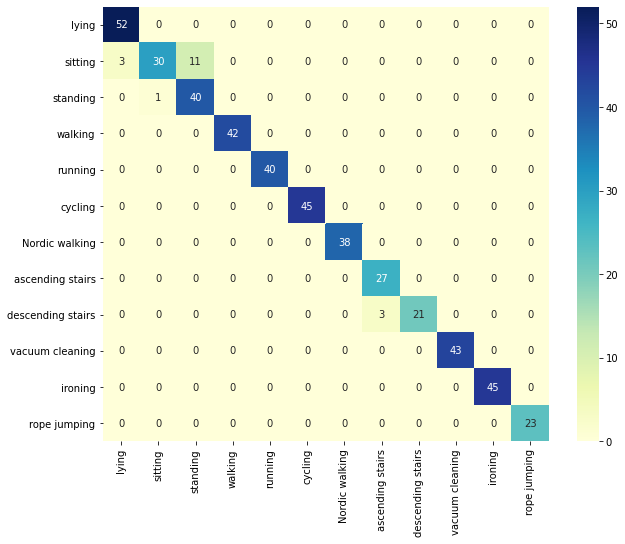

test sub ['subject102.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject102.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/30
49/49 - 7s - loss: 1.7845 - accuracy: 0.4106
Epoch 2/30
49/49 - 7s - loss: 0.4802 - accuracy: 0.8430
Epoch 3/30
49/49 - 7s - loss: 0.2080 - accuracy: 0.9376
Epoch 4/30
49/49 - 7s - loss: 0.1117 - accuracy: 0.9696
Epoch 5/30
49/49 - 7s - loss: 0.0888 - accuracy: 0.9767
Epoch 6/30
49/49 - 7s - loss: 0.1076 - accuracy: 0.9655
Epoch 7/30
49/49 - 7s - loss: 0.1039 - accuracy: 0.9690
Epoch 8/30
49/49 - 7s - loss: 0.0681 - accuracy: 0.9802
Epoch 9/30
49/49 - 7s - loss: 0.0961 - accuracy: 0.9712
Epoch 10/30
49/49 - 7s - loss: 0.0727 - accuracy: 0.9815
Epoch 11/30
49/49 - 7s - loss: 0.1037 - accuracy: 0.9680
Epoch 12/30
49/49 - 7s - loss: 0.1652 - accuracy: 0.9440
Epoch 13/30
49/49 - 7s - loss: 0.0485 - accuracy: 0.9878
Epoch 14/30
49/49 - 7s - loss: 0.0402 - accuracy: 0.9859
Epoch 15/30
49/49 - 7s - loss: 0.0681 - accuracy: 0.9786
Epoch 16/30
49/49 - 7s - loss: 0.1235 - accuracy: 0.9639
Epoch 17/30
49/49 - 7s - loss: 0.0571 - accuracy: 0.9818
Epoch 18/30
49/49 - 7s - loss: 0.0

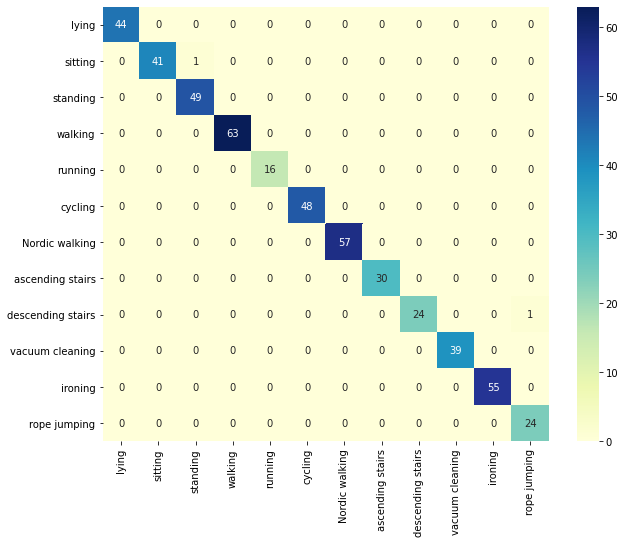

test sub ['subject103.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject103.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/30
52/52 - 7s - loss: 1.6167 - accuracy: 0.4378
Epoch 2/30
52/52 - 7s - loss: 0.4503 - accuracy: 0.8469
Epoch 3/30
52/52 - 7s - loss: 0.2076 - accuracy: 0.9339
Epoch 4/30
52/52 - 7s - loss: 0.1910 - accuracy: 0.9366
Epoch 5/30
52/52 - 7s - loss: 0.1085 - accuracy: 0.9703
Epoch 6/30
52/52 - 7s - loss: 0.0824 - accuracy: 0.9776
Epoch 7/30
52/52 - 7s - loss: 0.1591 - accuracy: 0.9536
Epoch 8/30
52/52 - 7s - loss: 0.1177 - accuracy: 0.9618
Epoch 9/30
52/52 - 7s - loss: 0.0516 - accuracy: 0.9851
Epoch 10/30
52/52 - 7s - loss: 0.0544 - accuracy: 0.9857
Epoch 11/30
52/52 - 7s - loss: 0.0894 - accuracy: 0.9742
Epoch 12/30
52/52 - 7s - loss: 0.0383 - accuracy: 0.9879
Epoch 13/30
52/52 - 7s - loss: 0.0336 - accuracy: 0.9894
Epoch 14/30
52/52 - 7s - loss: 0.0305 - accuracy: 0.9918
Epoch 15/30
52/52 - 7s - loss: 0.0334 - accuracy: 0.9891
Epoch 16/30
52/52 - 7s - loss: 0.0747 - accuracy: 0.9739
Epoch 17/30
52/52 - 7s - loss: 0.0609 - accuracy: 0.9836
Epoch 18/30
52/52 - 7s - loss: 0.1

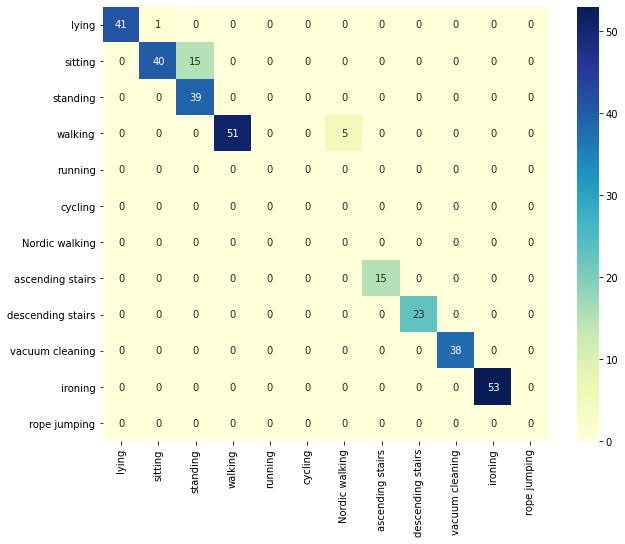

test sub ['subject104.dat']
{'train': ['subject109.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject104.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/30
50/50 - 7s - loss: 1.5215 - accuracy: 0.5038
Epoch 2/30
50/50 - 7s - loss: 0.5577 - accuracy: 0.8041
Epoch 3/30
50/50 - 7s - loss: 0.2507 - accuracy: 0.9234
Epoch 4/30
50/50 - 7s - loss: 0.1426 - accuracy: 0.9573
Epoch 5/30
50/50 - 7s - loss: 0.0969 - accuracy: 0.9708
Epoch 6/30
50/50 - 7s - loss: 0.1181 - accuracy: 0.9608
Epoch 7/30
50/50 - 7s - loss: 0.0710 - accuracy: 0.9805
Epoch 8/30
50/50 - 7s - loss: 0.0592 - accuracy: 0.9812
Epoch 9/30
50/50 - 7s - loss: 0.1037 - accuracy: 0.9727
Epoch 10/30
50/50 - 7s - loss: 0.1289 - accuracy: 0.9614
Epoch 11/30
50/50 - 7s - loss: 0.1073 - accuracy: 0.9611
Epoch 12/30
50/50 - 7s - loss: 0.0699 - accuracy: 0.9771
Epoch 13/30
50/50 - 7s - loss: 0.1124 - accuracy: 0.9623
Epoch 14/30
50/50 - 7s - loss: 0.1674 - accuracy: 0.9435
Epoch 15/30
50/50 - 7s - loss: 0.3048 - accuracy: 0.9218
Epoch 16/30
50/50 - 7s - loss: 0.1951 - accuracy: 0.9372
Epoch 17/30
50/50 - 7s - loss: 0.1297 - accuracy: 0.9605
Epoch 18/30
50/50 - 7s - loss: 0.0

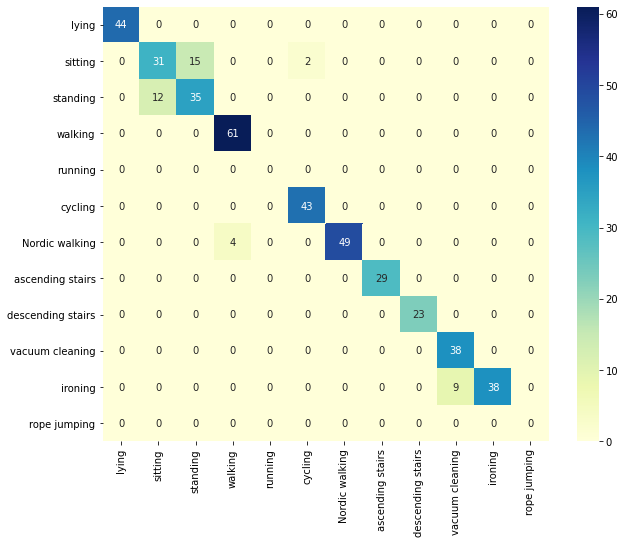

test sub ['subject105.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject105.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/30
49/49 - 7s - loss: 1.3252 - accuracy: 0.5484
Epoch 2/30
49/49 - 7s - loss: 0.3488 - accuracy: 0.8797
Epoch 3/30
49/49 - 7s - loss: 0.1965 - accuracy: 0.9341
Epoch 4/30
49/49 - 7s - loss: 0.1160 - accuracy: 0.9637
Epoch 5/30
49/49 - 7s - loss: 0.0742 - accuracy: 0.9797
Epoch 6/30
49/49 - 7s - loss: 0.1535 - accuracy: 0.9482
Epoch 7/30
49/49 - 7s - loss: 0.0803 - accuracy: 0.9759
Epoch 8/30
49/49 - 7s - loss: 0.1055 - accuracy: 0.9669
Epoch 9/30
49/49 - 7s - loss: 0.0792 - accuracy: 0.9775
Epoch 10/30
49/49 - 7s - loss: 0.0476 - accuracy: 0.9862
Epoch 11/30
49/49 - 7s - loss: 0.0630 - accuracy: 0.9794
Epoch 12/30
49/49 - 7s - loss: 0.1369 - accuracy: 0.9595
Epoch 13/30
49/49 - 7s - loss: 0.0843 - accuracy: 0.9752
Epoch 14/30
49/49 - 7s - loss: 0.0495 - accuracy: 0.9849
Epoch 15/30
49/49 - 7s - loss: 0.0563 - accuracy: 0.9833
Epoch 16/30
49/49 - 7s - loss: 0.0772 - accuracy: 0.9778
Epoch 17/30
49/49 - 7s - loss: 0.0678 - accuracy: 0.9768
Epoch 18/30
49/49 - 7s - loss: 0.0

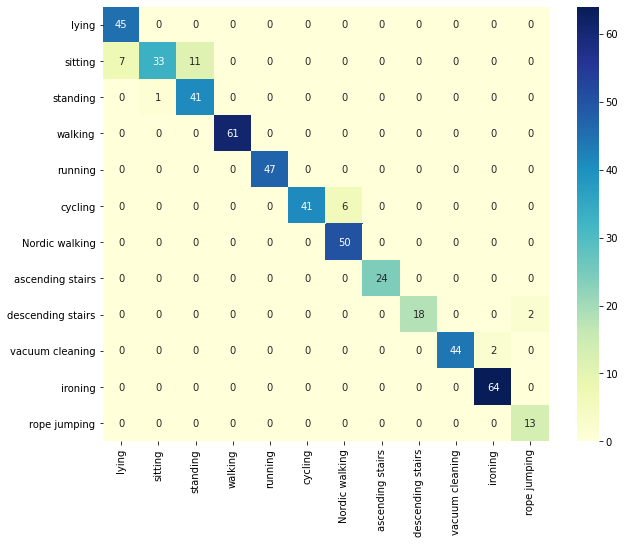

test sub ['subject106.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject106.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/30
50/50 - 7s - loss: 1.3594 - accuracy: 0.5684
Epoch 2/30
50/50 - 7s - loss: 0.2848 - accuracy: 0.9203
Epoch 3/30
50/50 - 7s - loss: 0.1975 - accuracy: 0.9375
Epoch 4/30
50/50 - 7s - loss: 0.1092 - accuracy: 0.9711
Epoch 5/30
50/50 - 7s - loss: 0.0966 - accuracy: 0.9724
Epoch 6/30
50/50 - 7s - loss: 0.1618 - accuracy: 0.9495
Epoch 7/30
50/50 - 7s - loss: 0.1004 - accuracy: 0.9714
Epoch 8/30
50/50 - 7s - loss: 0.1148 - accuracy: 0.9626
Epoch 9/30
50/50 - 7s - loss: 0.0640 - accuracy: 0.9813
Epoch 10/30
50/50 - 7s - loss: 0.0768 - accuracy: 0.9765
Epoch 11/30
50/50 - 7s - loss: 0.2986 - accuracy: 0.9295
Epoch 12/30
50/50 - 7s - loss: 0.0882 - accuracy: 0.9733
Epoch 13/30
50/50 - 7s - loss: 0.0481 - accuracy: 0.9864
Epoch 14/30
50/50 - 7s - loss: 0.0597 - accuracy: 0.9829
Epoch 15/30
50/50 - 7s - loss: 0.1872 - accuracy: 0.9416
Epoch 16/30
50/50 - 7s - loss: 0.0893 - accuracy: 0.9737
Epoch 17/30
50/50 - 7s - loss: 0.0447 - accuracy: 0.9873
Epoch 18/30
50/50 - 7s - loss: 0.0

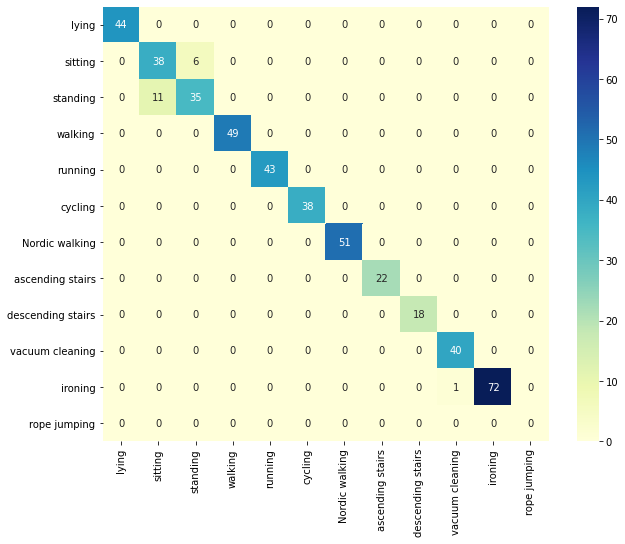

test sub ['subject107.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject107.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/30
50/50 - 7s - loss: 1.7702 - accuracy: 0.3871
Epoch 2/30
50/50 - 7s - loss: 0.5424 - accuracy: 0.7947
Epoch 3/30
50/50 - 7s - loss: 0.1916 - accuracy: 0.9416
Epoch 4/30
50/50 - 7s - loss: 0.1201 - accuracy: 0.9664
Epoch 5/30
50/50 - 7s - loss: 0.1076 - accuracy: 0.9677
Epoch 6/30
50/50 - 7s - loss: 0.1278 - accuracy: 0.9614
Epoch 7/30
50/50 - 7s - loss: 0.0949 - accuracy: 0.9699
Epoch 8/30
50/50 - 7s - loss: 0.0777 - accuracy: 0.9780
Epoch 9/30
50/50 - 7s - loss: 0.0797 - accuracy: 0.9761
Epoch 10/30
50/50 - 7s - loss: 0.1190 - accuracy: 0.9642
Epoch 11/30
50/50 - 7s - loss: 0.0771 - accuracy: 0.9780
Epoch 12/30
50/50 - 7s - loss: 0.2222 - accuracy: 0.9338
Epoch 13/30
50/50 - 7s - loss: 0.1120 - accuracy: 0.9673
Epoch 14/30
50/50 - 7s - loss: 0.0456 - accuracy: 0.9884
Epoch 15/30
50/50 - 7s - loss: 0.0452 - accuracy: 0.9874
Epoch 16/30
50/50 - 7s - loss: 0.0428 - accuracy: 0.9881
Epoch 17/30
50/50 - 7s - loss: 0.0384 - accuracy: 0.9874
Epoch 18/30
50/50 - 7s - loss: 0.0

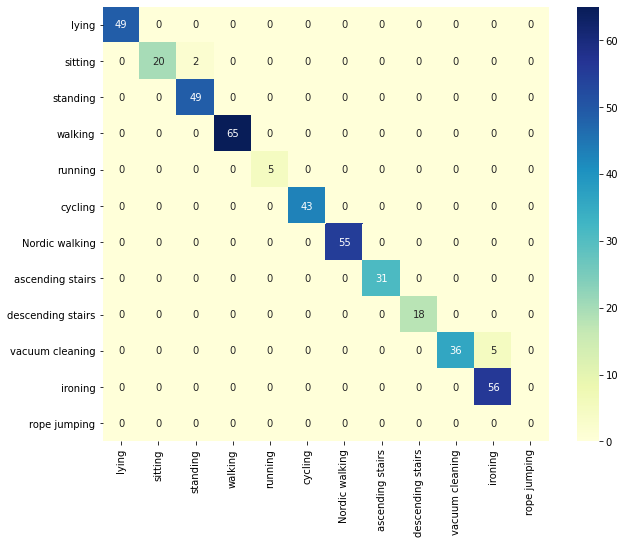

test sub ['subject108.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject101.dat'], 'test': ['subject108.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/30
49/49 - 7s - loss: 1.5654 - accuracy: 0.5048
Epoch 2/30
49/49 - 7s - loss: 0.4046 - accuracy: 0.8701
Epoch 3/30
49/49 - 7s - loss: 0.1946 - accuracy: 0.9384
Epoch 4/30
49/49 - 7s - loss: 0.1298 - accuracy: 0.9591
Epoch 5/30
49/49 - 7s - loss: 0.1305 - accuracy: 0.9626
Epoch 6/30
49/49 - 7s - loss: 0.1490 - accuracy: 0.9540
Epoch 7/30
49/49 - 7s - loss: 0.1405 - accuracy: 0.9591
Epoch 8/30
49/49 - 7s - loss: 0.1235 - accuracy: 0.9652
Epoch 9/30
49/49 - 7s - loss: 0.0979 - accuracy: 0.9697
Epoch 10/30
49/49 - 7s - loss: 0.0822 - accuracy: 0.9748
Epoch 11/30
49/49 - 7s - loss: 0.0510 - accuracy: 0.9847
Epoch 12/30
49/49 - 7s - loss: 0.0440 - accuracy: 0.9875
Epoch 13/30
49/49 - 7s - loss: 0.0659 - accuracy: 0.9808
Epoch 14/30
49/49 - 7s - loss: 0.0683 - accuracy: 0.9754
Epoch 15/30
49/49 - 7s - loss: 0.0542 - accuracy: 0.9844
Epoch 16/30
49/49 - 7s - loss: 0.0387 - accuracy: 0.9891
Epoch 17/30
49/49 - 7s - loss: 0.0167 - accuracy: 0.9958
Epoch 18/30
49/49 - 7s - loss: 0.0

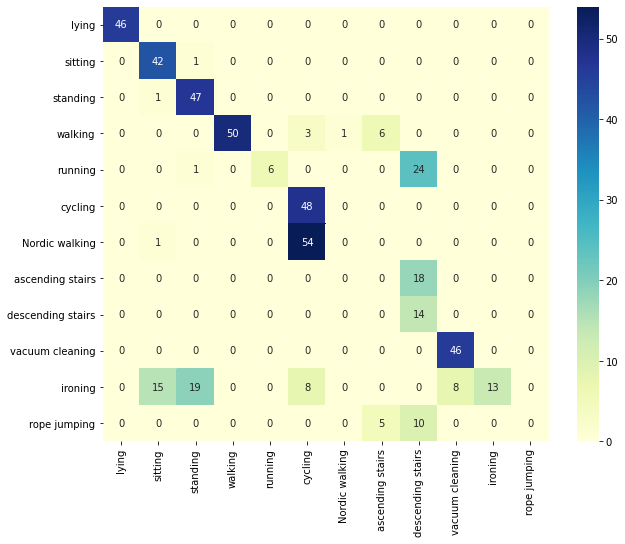

test sub ['subject109.dat']
{'train': ['subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject109.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1
Done.


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Epoch 1/30
57/57 - 8s - loss: 1.4010 - accuracy: 0.5309
Epoch 2/30
57/57 - 8s - loss: 0.3336 - accuracy: 0.8869
Epoch 3/30
57/57 - 8s - loss: 0.1723 - accuracy: 0.9449
Epoch 4/30
57/57 - 8s - loss: 0.2609 - accuracy: 0.9094
Epoch 5/30
57/57 - 8s - loss: 0.1103 - accuracy: 0.9673
Epoch 6/30
57/57 - 8s - loss: 0.0817 - accuracy: 0.9764
Epoch 7/30
57/57 - 8s - loss: 0.1052 - accuracy: 0.9681
Epoch 8/30
57/57 - 8s - loss: 0.1124 - accuracy: 0.9687
Epoch 9/30
57/57 - 8s - loss: 0.0697 - accuracy: 0.9795
Epoch 10/30
57/57 - 8s - loss: 0.1997 - accuracy: 0.9429
Epoch 11/30
57/57 - 8s - loss: 0.1274 - accuracy: 0.9620
Epoch 12/30
57/57 - 8s - loss: 0.0685 - accuracy: 0.9800
Epoch 13/30
57/57 - 8s - loss: 0.0764 - accuracy: 0.9778
Epoch 14/30
57/57 - 8s - loss: 0.0895 - accuracy: 0.9753
Epoch 15/30
57/57 - 8s - loss: 0.0499 - accuracy: 0.9859
Epoch 16/30
57/57 - 8s - loss: 0.0448 - accuracy: 0.9881
Epoch 17/30
57/57 - 8s - loss: 0.0508 - accuracy: 0.9856
Epoch 18/30
57/57 - 8s - loss: 0.0796 - 

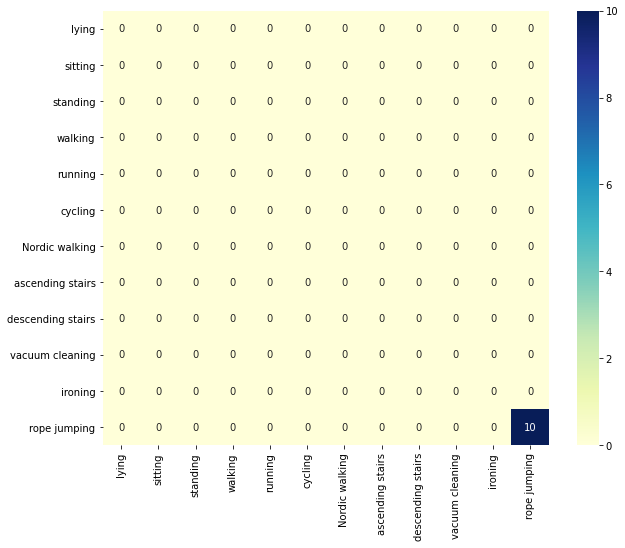

In [30]:
run_experiment()

test sub ['subject101.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat'], 'test': ['subject101.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
50/50 - 7s - loss: 1.4747 - accuracy: 0.5024
Epoch 2/40
50/50 - 7s - loss: 0.4389 - accuracy: 0.8447
Epoch 3/40
50/50 - 7s - loss: 0.2529 - accuracy: 0.9201
Epoch 4/40
50/50 - 7s - loss: 0.2435 - accuracy: 0.9128
Epoch 5/40
50/50 - 7s - loss: 0.1608 - accuracy: 0.9452
Epoch 6/40
50/50 - 7s - loss: 0.1576 - accuracy: 0.9429
Epoch 7/40
50/50 - 7s - loss: 0.1397 - accuracy: 0.9458
Epoch 8/40
50/50 - 7s - loss: 0.1064 - accuracy: 0.9623
Epoch 9/40
50/50 - 7s - loss: 0.1119 - accuracy: 0.9547
Epoch 10/40
50/50 - 7s - loss: 0.0778 - accuracy: 0.9686
Epoch 11/40
50/50 - 7s - loss: 0.0704 - accuracy: 0.9769
Epoch 12/40
50/50 - 7s - loss: 0.1173 - accuracy: 0.9664
Epoch 13/40
50/50 - 7s - loss: 0.1438 - accuracy: 0.9559
Epoch 14/40
50/50 - 7s - loss: 0.1175 - accuracy: 0.9635
Epoch 15/40
50/50 - 7s - loss: 0.0577 - accuracy: 0.9823
Epoch 16/40
50/50 - 7s - loss: 0.0561 - accuracy: 0.9842
Epoch 17/40
50/50 - 7s - loss: 0.0259 - accuracy: 0.9924
Epoch 18/40
50/50 - 7s - loss: 0.0

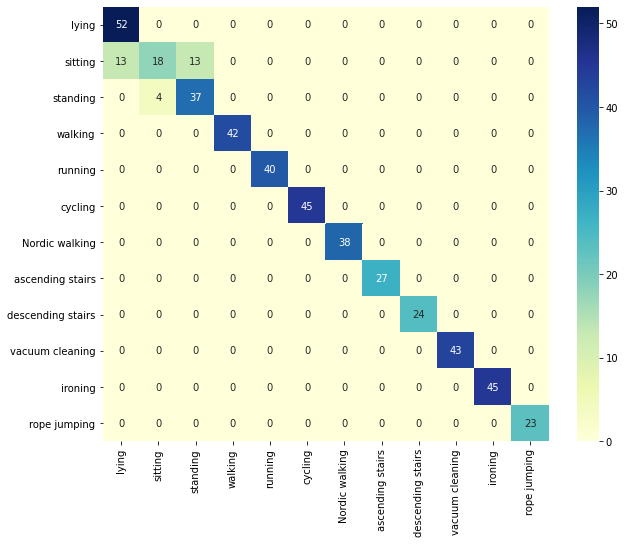

test sub ['subject102.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject102.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.8187 - accuracy: 0.3454
Epoch 2/40
49/49 - 7s - loss: 0.7269 - accuracy: 0.7378
Epoch 3/40
49/49 - 7s - loss: 0.3078 - accuracy: 0.8833
Epoch 4/40
49/49 - 7s - loss: 0.1937 - accuracy: 0.9370
Epoch 5/40
49/49 - 7s - loss: 0.2228 - accuracy: 0.9268
Epoch 6/40
49/49 - 7s - loss: 0.1266 - accuracy: 0.9597
Epoch 7/40
49/49 - 7s - loss: 0.0586 - accuracy: 0.9827
Epoch 8/40
49/49 - 7s - loss: 0.1130 - accuracy: 0.9623
Epoch 9/40
49/49 - 7s - loss: 0.1330 - accuracy: 0.9600
Epoch 10/40
49/49 - 7s - loss: 0.2128 - accuracy: 0.9402
Epoch 11/40
49/49 - 7s - loss: 0.1000 - accuracy: 0.9709
Epoch 12/40
49/49 - 7s - loss: 0.0715 - accuracy: 0.9786
Epoch 13/40
49/49 - 7s - loss: 0.0568 - accuracy: 0.9827
Epoch 14/40
49/49 - 7s - loss: 0.0560 - accuracy: 0.9824
Epoch 15/40
49/49 - 7s - loss: 0.0314 - accuracy: 0.9901
Epoch 16/40
49/49 - 7s - loss: 0.0332 - accuracy: 0.9920
Epoch 17/40
49/49 - 7s - loss: 0.0313 - accuracy: 0.9914
Epoch 18/40
49/49 - 7s - loss: 0.0

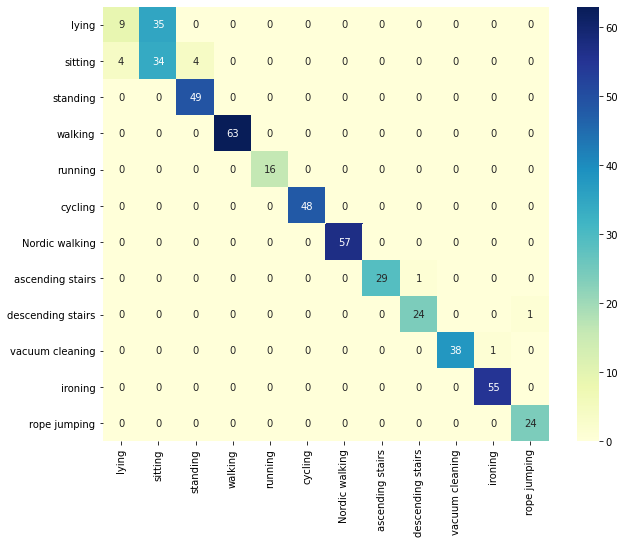

test sub ['subject103.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject103.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
52/52 - 7s - loss: 1.4216 - accuracy: 0.5309
Epoch 2/40
52/52 - 7s - loss: 0.2530 - accuracy: 0.9287
Epoch 3/40
52/52 - 7s - loss: 0.1568 - accuracy: 0.9582
Epoch 4/40
52/52 - 7s - loss: 0.0947 - accuracy: 0.9745
Epoch 5/40
52/52 - 7s - loss: 0.1384 - accuracy: 0.9585
Epoch 6/40
52/52 - 7s - loss: 0.2649 - accuracy: 0.9142
Epoch 7/40
52/52 - 7s - loss: 0.0905 - accuracy: 0.9754
Epoch 8/40
52/52 - 7s - loss: 0.0691 - accuracy: 0.9809
Epoch 9/40
52/52 - 7s - loss: 0.0962 - accuracy: 0.9691
Epoch 10/40
52/52 - 7s - loss: 0.1086 - accuracy: 0.9676
Epoch 11/40
52/52 - 7s - loss: 0.0773 - accuracy: 0.9794
Epoch 12/40
52/52 - 7s - loss: 0.0453 - accuracy: 0.9891
Epoch 13/40
52/52 - 7s - loss: 0.0748 - accuracy: 0.9754
Epoch 14/40
52/52 - 7s - loss: 0.1252 - accuracy: 0.9624
Epoch 15/40
52/52 - 7s - loss: 0.1093 - accuracy: 0.9691
Epoch 16/40
52/52 - 7s - loss: 0.0619 - accuracy: 0.9824
Epoch 17/40
52/52 - 7s - loss: 0.0877 - accuracy: 0.9733
Epoch 18/40
52/52 - 7s - loss: 0.0

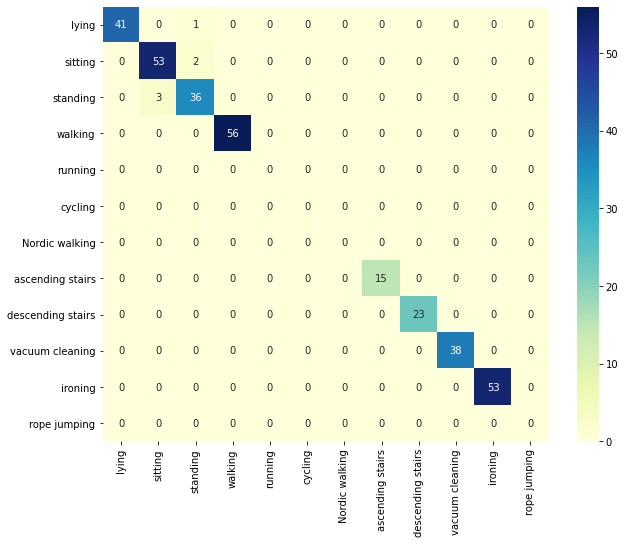

test sub ['subject104.dat']
{'train': ['subject109.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject104.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
50/50 - 7s - loss: 1.2988 - accuracy: 0.5744
Epoch 2/40
50/50 - 7s - loss: 0.2952 - accuracy: 0.9099
Epoch 3/40
50/50 - 7s - loss: 0.1820 - accuracy: 0.9476
Epoch 4/40
50/50 - 7s - loss: 0.2584 - accuracy: 0.9175
Epoch 5/40
50/50 - 7s - loss: 0.1136 - accuracy: 0.9677
Epoch 6/40
50/50 - 7s - loss: 0.0917 - accuracy: 0.9721
Epoch 7/40
50/50 - 7s - loss: 0.0441 - accuracy: 0.9874
Epoch 8/40
50/50 - 7s - loss: 0.0463 - accuracy: 0.9865
Epoch 9/40
50/50 - 7s - loss: 0.0414 - accuracy: 0.9881
Epoch 10/40
50/50 - 7s - loss: 0.0909 - accuracy: 0.9736
Epoch 11/40
50/50 - 7s - loss: 0.0903 - accuracy: 0.9724
Epoch 12/40
50/50 - 7s - loss: 0.0372 - accuracy: 0.9893
Epoch 13/40
50/50 - 7s - loss: 0.0523 - accuracy: 0.9831
Epoch 14/40
50/50 - 7s - loss: 0.1514 - accuracy: 0.9586
Epoch 15/40
50/50 - 7s - loss: 0.1102 - accuracy: 0.9655
Epoch 16/40
50/50 - 7s - loss: 0.0529 - accuracy: 0.9840
Epoch 17/40
50/50 - 7s - loss: 0.0266 - accuracy: 0.9928
Epoch 18/40
50/50 - 7s - loss: 0.0

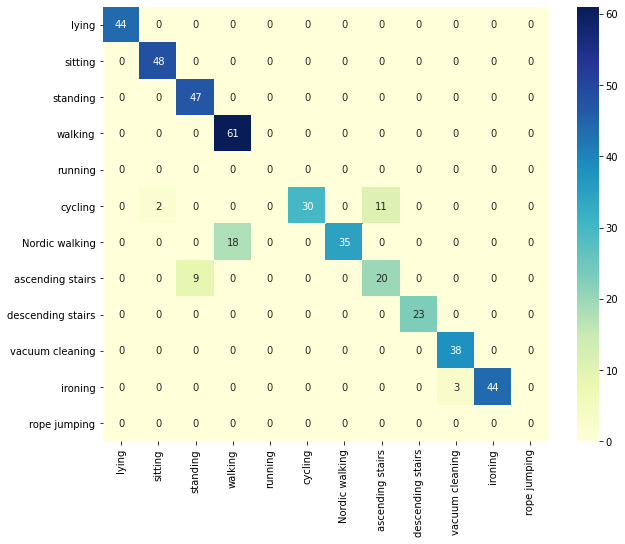

test sub ['subject105.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject105.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.7756 - accuracy: 0.3828
Epoch 2/40
49/49 - 7s - loss: 0.5469 - accuracy: 0.7958
Epoch 3/40
49/49 - 7s - loss: 0.6052 - accuracy: 0.7832
Epoch 4/40
49/49 - 7s - loss: 0.2472 - accuracy: 0.9177
Epoch 5/40
49/49 - 7s - loss: 0.1436 - accuracy: 0.9559
Epoch 6/40
49/49 - 7s - loss: 0.1610 - accuracy: 0.9511
Epoch 7/40
49/49 - 7s - loss: 0.1540 - accuracy: 0.9524
Epoch 8/40
49/49 - 7s - loss: 0.1399 - accuracy: 0.9540
Epoch 9/40
49/49 - 7s - loss: 0.1047 - accuracy: 0.9682
Epoch 10/40
49/49 - 7s - loss: 0.1633 - accuracy: 0.9489
Epoch 11/40
49/49 - 7s - loss: 0.1780 - accuracy: 0.9456
Epoch 12/40
49/49 - 7s - loss: 0.1798 - accuracy: 0.9456
Epoch 13/40
49/49 - 7s - loss: 0.0794 - accuracy: 0.9791
Epoch 14/40
49/49 - 7s - loss: 0.0953 - accuracy: 0.9714
Epoch 15/40
49/49 - 7s - loss: 0.0674 - accuracy: 0.9823
Epoch 16/40
49/49 - 7s - loss: 0.0755 - accuracy: 0.9788
Epoch 17/40
49/49 - 7s - loss: 0.1144 - accuracy: 0.9637
Epoch 18/40
49/49 - 7s - loss: 0.1

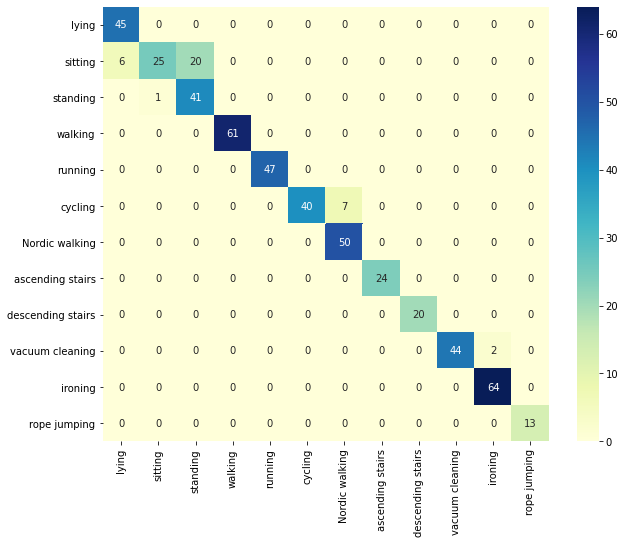

test sub ['subject106.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject106.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
50/50 - 7s - loss: 1.7609 - accuracy: 0.4030
Epoch 2/40
50/50 - 7s - loss: 0.4276 - accuracy: 0.8661
Epoch 3/40
50/50 - 7s - loss: 0.1930 - accuracy: 0.9511
Epoch 4/40
50/50 - 7s - loss: 0.1310 - accuracy: 0.9616
Epoch 5/40
50/50 - 7s - loss: 0.0908 - accuracy: 0.9737
Epoch 6/40
50/50 - 7s - loss: 0.1547 - accuracy: 0.9524
Epoch 7/40
50/50 - 7s - loss: 0.1637 - accuracy: 0.9480
Epoch 8/40
50/50 - 7s - loss: 0.1023 - accuracy: 0.9657
Epoch 9/40
50/50 - 7s - loss: 0.0567 - accuracy: 0.9829
Epoch 10/40
50/50 - 7s - loss: 0.0296 - accuracy: 0.9911
Epoch 11/40
50/50 - 7s - loss: 0.0527 - accuracy: 0.9835
Epoch 12/40
50/50 - 7s - loss: 0.0542 - accuracy: 0.9848
Epoch 13/40
50/50 - 7s - loss: 0.0506 - accuracy: 0.9876
Epoch 14/40
50/50 - 7s - loss: 0.1468 - accuracy: 0.9562
Epoch 15/40
50/50 - 7s - loss: 0.0859 - accuracy: 0.9759
Epoch 16/40
50/50 - 7s - loss: 0.0402 - accuracy: 0.9883
Epoch 17/40
50/50 - 7s - loss: 0.0793 - accuracy: 0.9794
Epoch 18/40
50/50 - 7s - loss: 0.1

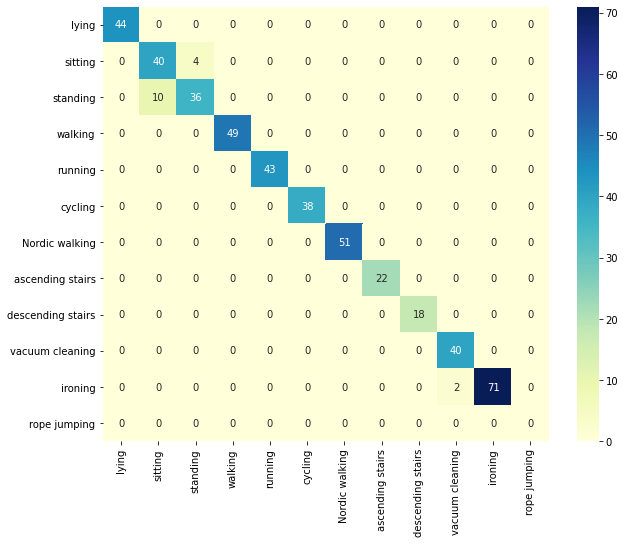

test sub ['subject107.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject107.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
50/50 - 7s - loss: 1.4519 - accuracy: 0.4976
Epoch 2/40
50/50 - 7s - loss: 0.3871 - accuracy: 0.8590
Epoch 3/40
50/50 - 7s - loss: 0.2731 - accuracy: 0.9024
Epoch 4/40
50/50 - 7s - loss: 0.1545 - accuracy: 0.9451
Epoch 5/40
50/50 - 7s - loss: 0.1408 - accuracy: 0.9429
Epoch 6/40
50/50 - 7s - loss: 0.1318 - accuracy: 0.9510
Epoch 7/40
50/50 - 7s - loss: 0.1595 - accuracy: 0.9476
Epoch 8/40
50/50 - 7s - loss: 0.1785 - accuracy: 0.9416
Epoch 9/40
50/50 - 7s - loss: 0.1057 - accuracy: 0.9664
Epoch 10/40
50/50 - 7s - loss: 0.0821 - accuracy: 0.9746
Epoch 11/40
50/50 - 7s - loss: 0.0750 - accuracy: 0.9783
Epoch 12/40
50/50 - 7s - loss: 0.0649 - accuracy: 0.9818
Epoch 13/40
50/50 - 7s - loss: 0.1862 - accuracy: 0.9463
Epoch 14/40
50/50 - 7s - loss: 0.2012 - accuracy: 0.9397
Epoch 15/40
50/50 - 7s - loss: 0.0908 - accuracy: 0.9702
Epoch 16/40
50/50 - 7s - loss: 0.0724 - accuracy: 0.9793
Epoch 17/40
50/50 - 7s - loss: 0.0763 - accuracy: 0.9761
Epoch 18/40
50/50 - 7s - loss: 0.1

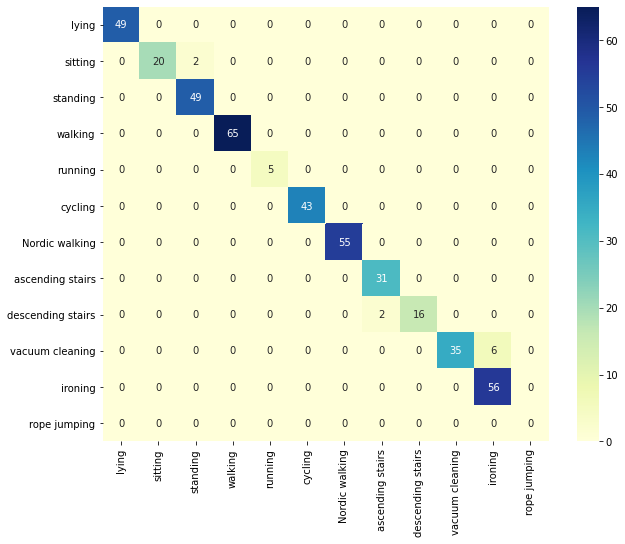

test sub ['subject108.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject101.dat'], 'test': ['subject108.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.3374 - accuracy: 0.5597
Epoch 2/40
49/49 - 7s - loss: 0.2713 - accuracy: 0.9119
Epoch 3/40
49/49 - 7s - loss: 0.1796 - accuracy: 0.9393
Epoch 4/40
49/49 - 7s - loss: 0.1698 - accuracy: 0.9470
Epoch 5/40
49/49 - 7s - loss: 0.0723 - accuracy: 0.9783
Epoch 6/40
49/49 - 7s - loss: 0.0816 - accuracy: 0.9767
Epoch 7/40
49/49 - 7s - loss: 0.0475 - accuracy: 0.9866
Epoch 8/40
49/49 - 7s - loss: 0.0951 - accuracy: 0.9738
Epoch 9/40
49/49 - 7s - loss: 0.0485 - accuracy: 0.9834
Epoch 10/40
49/49 - 7s - loss: 0.0756 - accuracy: 0.9777
Epoch 11/40
49/49 - 7s - loss: 0.1610 - accuracy: 0.9496
Epoch 12/40
49/49 - 7s - loss: 0.1175 - accuracy: 0.9617
Epoch 13/40
49/49 - 7s - loss: 0.0950 - accuracy: 0.9722
Epoch 14/40
49/49 - 7s - loss: 0.1124 - accuracy: 0.9662
Epoch 15/40
49/49 - 7s - loss: 0.0669 - accuracy: 0.9815
Epoch 16/40
49/49 - 7s - loss: 0.1181 - accuracy: 0.9636
Epoch 17/40
49/49 - 7s - loss: 0.0739 - accuracy: 0.9786
Epoch 18/40
49/49 - 7s - loss: 0.0

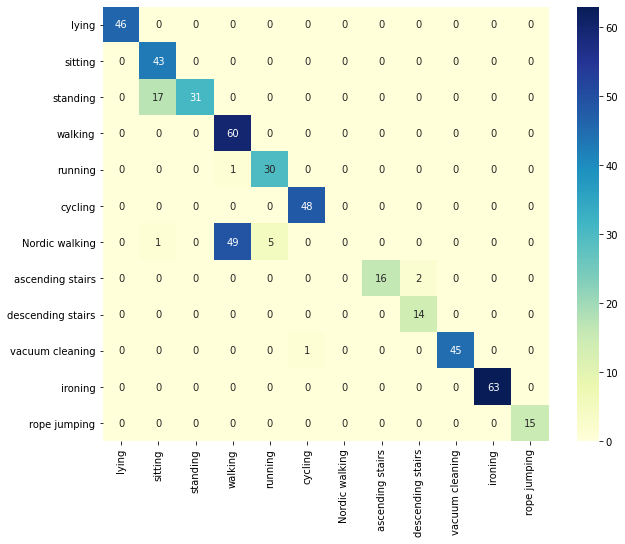

test sub ['subject109.dat']
{'train': ['subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject109.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1
Done.


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Epoch 1/40
57/57 - 8s - loss: 1.2489 - accuracy: 0.5603
Epoch 2/40
57/57 - 8s - loss: 0.3023 - accuracy: 0.9069
Epoch 3/40
57/57 - 8s - loss: 0.1396 - accuracy: 0.9590
Epoch 4/40
57/57 - 8s - loss: 0.1266 - accuracy: 0.9637
Epoch 5/40
57/57 - 8s - loss: 0.1015 - accuracy: 0.9728
Epoch 6/40
57/57 - 8s - loss: 0.0903 - accuracy: 0.9723
Epoch 7/40
57/57 - 8s - loss: 0.0836 - accuracy: 0.9748
Epoch 8/40
57/57 - 8s - loss: 0.1497 - accuracy: 0.9557
Epoch 9/40
57/57 - 8s - loss: 0.0979 - accuracy: 0.9709
Epoch 10/40
57/57 - 8s - loss: 0.1282 - accuracy: 0.9612
Epoch 11/40
57/57 - 8s - loss: 0.0790 - accuracy: 0.9751
Epoch 12/40
57/57 - 8s - loss: 0.1940 - accuracy: 0.9432
Epoch 13/40
57/57 - 8s - loss: 0.0854 - accuracy: 0.9740
Epoch 14/40
57/57 - 8s - loss: 0.0602 - accuracy: 0.9820
Epoch 15/40
57/57 - 8s - loss: 0.0594 - accuracy: 0.9817
Epoch 16/40
57/57 - 8s - loss: 0.0542 - accuracy: 0.9828
Epoch 17/40
57/57 - 8s - loss: 0.0494 - accuracy: 0.9842
Epoch 18/40
57/57 - 8s - loss: 0.0646 - 

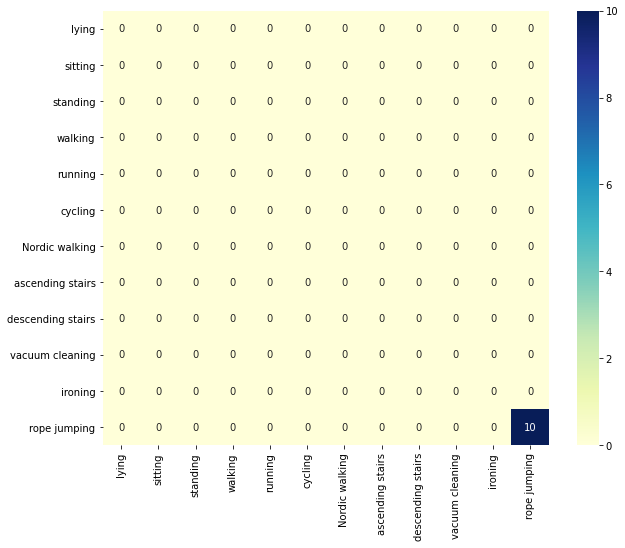

In [43]:
run_experiment()

test sub ['subject101.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject102.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat'], 'test': ['subject101.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
50/50 - 7s - loss: 1.3681 - accuracy: 0.5417
Epoch 2/40
50/50 - 7s - loss: 0.3028 - accuracy: 0.9024
Epoch 3/40
50/50 - 7s - loss: 0.1855 - accuracy: 0.9423
Epoch 4/40
50/50 - 7s - loss: 0.1236 - accuracy: 0.9680
Epoch 5/40
50/50 - 7s - loss: 0.1049 - accuracy: 0.9708
Epoch 6/40
50/50 - 7s - loss: 0.1438 - accuracy: 0.9553
Epoch 7/40
50/50 - 7s - loss: 0.1152 - accuracy: 0.9620
Epoch 8/40
50/50 - 7s - loss: 0.2310 - accuracy: 0.9261
Epoch 9/40
50/50 - 7s - loss: 0.0796 - accuracy: 0.9791
Epoch 10/40
50/50 - 7s - loss: 0.0687 - accuracy: 0.9784
Epoch 11/40
50/50 - 7s - loss: 0.1208 - accuracy: 0.9667
Epoch 12/40
50/50 - 7s - loss: 0.0623 - accuracy: 0.9829
Epoch 13/40
50/50 - 7s - loss: 0.0786 - accuracy: 0.9769
Epoch 14/40
50/50 - 7s - loss: 0.0355 - accuracy: 0.9905
Epoch 15/40
50/50 - 7s - loss: 0.0334 - accuracy: 0.9905
Epoch 16/40
50/50 - 7s - loss: 0.0668 - accuracy: 0.9807
Epoch 17/40
50/50 - 7s - loss: 0.1276 - accuracy: 0.9626
Epoch 18/40
50/50 - 7s - loss: 0.1

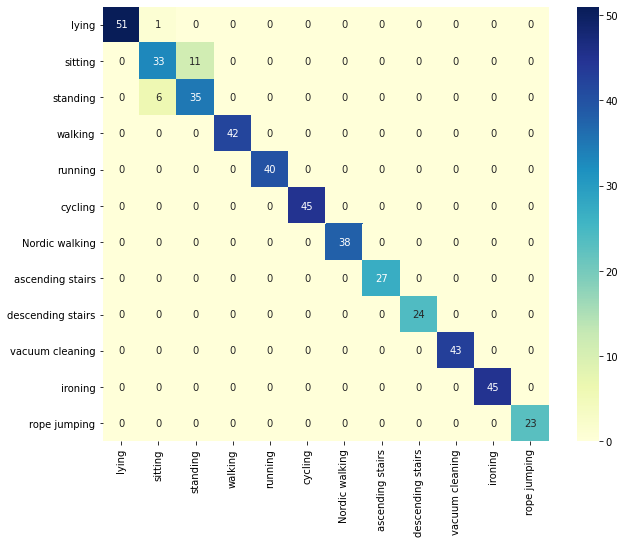

test sub ['subject102.dat']
{'train': ['subject109.dat', 'subject104.dat', 'subject107.dat', 'subject106.dat', 'subject103.dat', 'subject105.dat', 'subject108.dat', 'subject101.dat'], 'test': ['subject102.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.3670 - accuracy: 0.5174
Epoch 2/40
49/49 - 7s - loss: 0.4088 - accuracy: 0.8679
Epoch 3/40
49/49 - 7s - loss: 0.2627 - accuracy: 0.9143
Epoch 4/40
49/49 - 7s - loss: 0.2099 - accuracy: 0.9293
Epoch 5/40
49/49 - 7s - loss: 0.2695 - accuracy: 0.9057
Epoch 6/40
49/49 - 7s - loss: 0.1126 - accuracy: 0.9648
Epoch 7/40
49/49 - 7s - loss: 0.0613 - accuracy: 0.9834
Epoch 8/40
49/49 - 7s - loss: 0.0559 - accuracy: 0.9837
Epoch 9/40
49/49 - 7s - loss: 0.0837 - accuracy: 0.9770
Epoch 10/40
49/49 - 7s - loss: 0.1741 - accuracy: 0.9386
Epoch 11/40
49/49 - 7s - loss: 0.0928 - accuracy: 0.9731
Epoch 12/40
49/49 - 7s - loss: 0.0546 - accuracy: 0.9859
Epoch 13/40
49/49 - 7s - loss: 0.0493 - accuracy: 0.9859
Epoch 14/40
49/49 - 7s - loss: 0.3158 - accuracy: 0.9044
Epoch 15/40
49/49 - 7s - loss: 0.0896 - accuracy: 0.9715
Epoch 16/40
49/49 - 7s - loss: 0.1386 - accuracy: 0.9568
Epoch 17/40
49/49 - 7s - loss: 0.2496 - accuracy: 0.9162
Epoch 18/40
49/49 - 7s - loss: 0.1

In [ ]:
run_experiment()

In [26]:
!rm *.h5

test sub ['subject101.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject109.dat'], 'test': ['subject101.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.3449 - accuracy: 0.5664
Epoch 2/40
49/49 - 7s - loss: 0.2881 - accuracy: 0.9150
Epoch 3/40
49/49 - 7s - loss: 0.2421 - accuracy: 0.9227
Epoch 4/40
49/49 - 7s - loss: 0.1294 - accuracy: 0.9618
Epoch 5/40
49/49 - 7s - loss: 0.1804 - accuracy: 0.9451
Epoch 6/40
49/49 - 7s - loss: 0.1198 - accuracy: 0.9669
Epoch 7/40
49/49 - 7s - loss: 0.1102 - accuracy: 0.9692
Epoch 8/40
49/49 - 7s - loss: 0.0369 - accuracy: 0.9907
Epoch 9/40
49/49 - 7s - loss: 0.1008 - accuracy: 0.9657
Epoch 10/40
49/49 - 7s - loss: 0.1311 - accuracy: 0.9628
Epoch 11/40
49/49 - 7s - loss: 0.0368 - accuracy: 0.9884
Epoch 12/40
49/49 - 7s - loss: 0.0420 - accuracy: 0.9865
Epoch 13/40
49/49 - 7s - loss: 0.0653 - accuracy: 0.9811
Epoch 14/40
49/49 - 7s - loss: 0.0744 - accuracy: 0.9769
Epoch 15/40
49/49 - 7s - loss: 0.0366 - accuracy: 0.9888
Epoch 16/40
49/49 - 7s - loss: 0.0237 - accuracy: 0.9913
Epoch 17/40
49/49 - 7s - loss: 0.0350 - accuracy: 0.9878
Epoch 18/40
49/49 - 7s - loss: 0.0

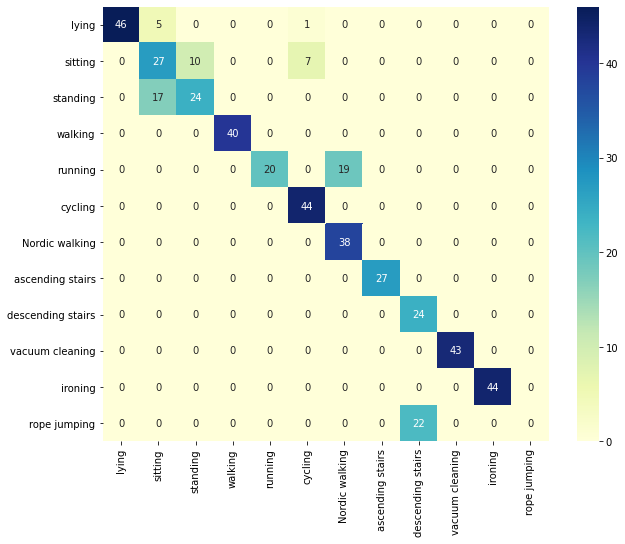

test sub ['subject102.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject102.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.6372 - accuracy: 0.4483
Epoch 2/40
49/49 - 7s - loss: 0.3239 - accuracy: 0.9063
Epoch 3/40
49/49 - 7s - loss: 0.1816 - accuracy: 0.9480
Epoch 4/40
49/49 - 7s - loss: 0.1390 - accuracy: 0.9583
Epoch 5/40
49/49 - 7s - loss: 0.2025 - accuracy: 0.9405
Epoch 6/40
49/49 - 7s - loss: 0.0776 - accuracy: 0.9793
Epoch 7/40
49/49 - 7s - loss: 0.0344 - accuracy: 0.9932
Epoch 8/40
49/49 - 7s - loss: 0.0279 - accuracy: 0.9922
Epoch 9/40
49/49 - 7s - loss: 0.0424 - accuracy: 0.9871
Epoch 10/40
49/49 - 7s - loss: 0.0553 - accuracy: 0.9832
Epoch 11/40
49/49 - 7s - loss: 0.0878 - accuracy: 0.9729
Epoch 12/40
49/49 - 7s - loss: 0.0640 - accuracy: 0.9829
Epoch 13/40
49/49 - 7s - loss: 0.0324 - accuracy: 0.9913
Epoch 14/40
49/49 - 7s - loss: 0.0250 - accuracy: 0.9935
Epoch 15/40
49/49 - 7s - loss: 0.0209 - accuracy: 0.9952
Epoch 16/40
49/49 - 7s - loss: 0.0709 - accuracy: 0.9800
Epoch 17/40
49/49 - 7s - loss: 0.1756 - accuracy: 0.9560
Epoch 18/40
49/49 - 7s - loss: 0.1

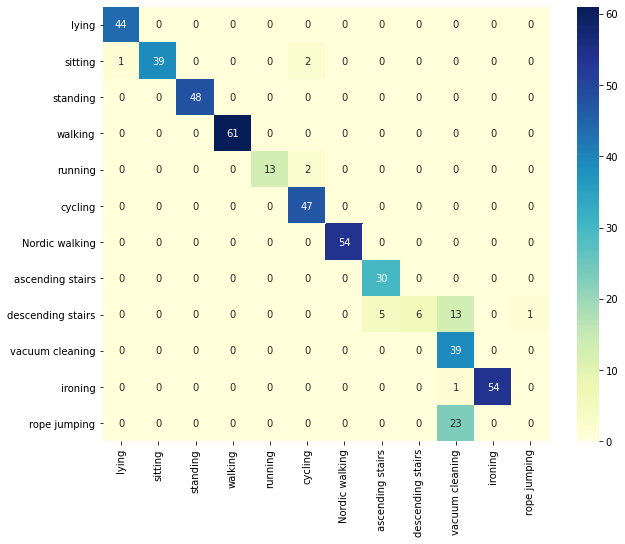

test sub ['subject103.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject103.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
51/51 - 7s - loss: 1.5554 - accuracy: 0.5081
Epoch 2/40
51/51 - 7s - loss: 0.2420 - accuracy: 0.9251
Epoch 3/40
51/51 - 7s - loss: 0.0754 - accuracy: 0.9840
Epoch 4/40
51/51 - 7s - loss: 0.0999 - accuracy: 0.9708
Epoch 5/40
51/51 - 7s - loss: 0.1544 - accuracy: 0.9620
Epoch 6/40
51/51 - 7s - loss: 0.0954 - accuracy: 0.9690
Epoch 7/40
51/51 - 7s - loss: 0.0276 - accuracy: 0.9939
Epoch 8/40
51/51 - 7s - loss: 0.0295 - accuracy: 0.9917
Epoch 9/40
51/51 - 7s - loss: 0.0486 - accuracy: 0.9856
Epoch 10/40
51/51 - 7s - loss: 0.0546 - accuracy: 0.9840
Epoch 11/40
51/51 - 7s - loss: 0.0643 - accuracy: 0.9816
Epoch 12/40
51/51 - 7s - loss: 0.0267 - accuracy: 0.9942
Epoch 13/40
51/51 - 7s - loss: 0.2273 - accuracy: 0.9521
Epoch 14/40
51/51 - 7s - loss: 0.3176 - accuracy: 0.9046
Epoch 15/40
51/51 - 7s - loss: 0.0416 - accuracy: 0.9923
Epoch 16/40
51/51 - 7s - loss: 0.0197 - accuracy: 0.9951
Epoch 17/40
51/51 - 7s - loss: 0.0102 - accuracy: 0.9985
Epoch 18/40
51/51 - 7s - loss: 0.0

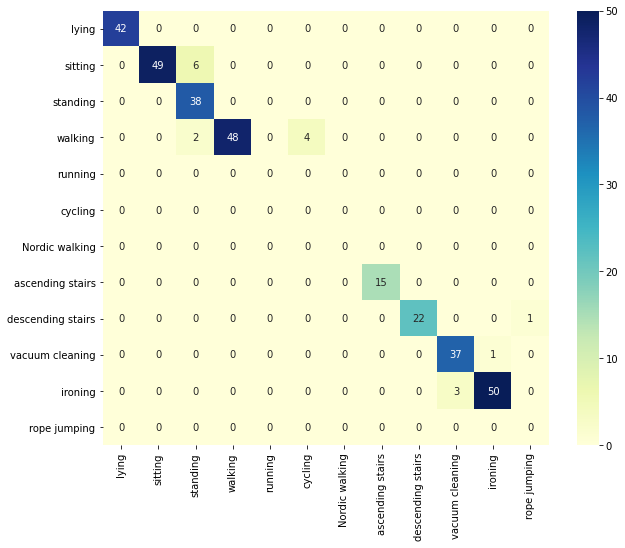

test sub ['subject104.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject104.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
50/50 - 7s - loss: 1.6646 - accuracy: 0.4254
Epoch 2/40
50/50 - 7s - loss: 0.6084 - accuracy: 0.7527
Epoch 3/40
50/50 - 7s - loss: 0.3071 - accuracy: 0.8933
Epoch 4/40
50/50 - 7s - loss: 0.1585 - accuracy: 0.9521
Epoch 5/40
50/50 - 7s - loss: 0.0583 - accuracy: 0.9848
Epoch 6/40
50/50 - 7s - loss: 0.0467 - accuracy: 0.9870
Epoch 7/40
50/50 - 7s - loss: 0.1581 - accuracy: 0.9549
Epoch 8/40
50/50 - 7s - loss: 0.1058 - accuracy: 0.9632
Epoch 9/40
50/50 - 7s - loss: 0.0484 - accuracy: 0.9883
Epoch 10/40
50/50 - 7s - loss: 0.0608 - accuracy: 0.9784
Epoch 11/40
50/50 - 7s - loss: 0.0560 - accuracy: 0.9854
Epoch 12/40
50/50 - 7s - loss: 0.1055 - accuracy: 0.9670
Epoch 13/40
50/50 - 7s - loss: 0.0875 - accuracy: 0.9711
Epoch 14/40
50/50 - 7s - loss: 0.0419 - accuracy: 0.9873
Epoch 15/40
50/50 - 7s - loss: 0.1061 - accuracy: 0.9737
Epoch 16/40
50/50 - 7s - loss: 0.1084 - accuracy: 0.9692
Epoch 17/40
50/50 - 7s - loss: 0.0251 - accuracy: 0.9959
Epoch 18/40
50/50 - 7s - loss: 0.0

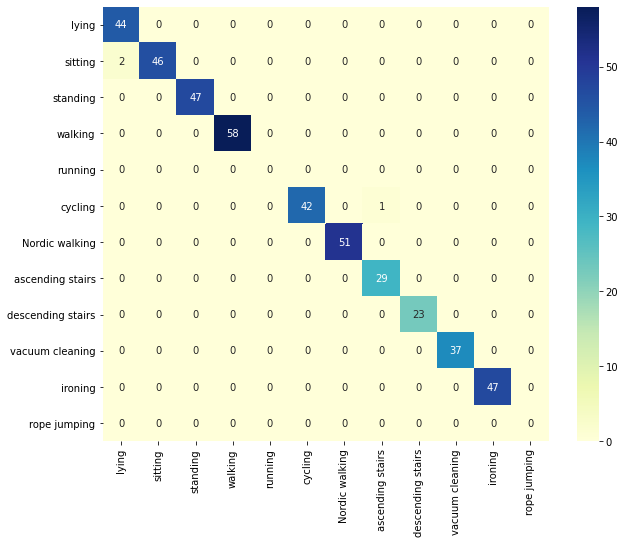

test sub ['subject105.dat']
{'train': ['subject108.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject105.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.3405 - accuracy: 0.5319
Epoch 2/40
49/49 - 7s - loss: 0.3394 - accuracy: 0.8923
Epoch 3/40
49/49 - 7s - loss: 0.1849 - accuracy: 0.9414
Epoch 4/40
49/49 - 7s - loss: 0.1300 - accuracy: 0.9629
Epoch 5/40
49/49 - 7s - loss: 0.0520 - accuracy: 0.9896
Epoch 6/40
49/49 - 7s - loss: 0.1293 - accuracy: 0.9623
Epoch 7/40
49/49 - 7s - loss: 0.0580 - accuracy: 0.9860
Epoch 8/40
49/49 - 7s - loss: 0.1092 - accuracy: 0.9701
Epoch 9/40
49/49 - 7s - loss: 0.0791 - accuracy: 0.9789
Epoch 10/40
49/49 - 7s - loss: 0.0623 - accuracy: 0.9841
Epoch 11/40
49/49 - 7s - loss: 0.0244 - accuracy: 0.9945
Epoch 12/40
49/49 - 7s - loss: 0.1198 - accuracy: 0.9642
Epoch 13/40
49/49 - 7s - loss: 0.0518 - accuracy: 0.9863
Epoch 14/40
49/49 - 7s - loss: 0.0280 - accuracy: 0.9932
Epoch 15/40
49/49 - 7s - loss: 0.0293 - accuracy: 0.9899
Epoch 16/40
49/49 - 7s - loss: 0.0283 - accuracy: 0.9902
Epoch 17/40
49/49 - 7s - loss: 0.0259 - accuracy: 0.9925
Epoch 18/40
49/49 - 7s - loss: 0.0

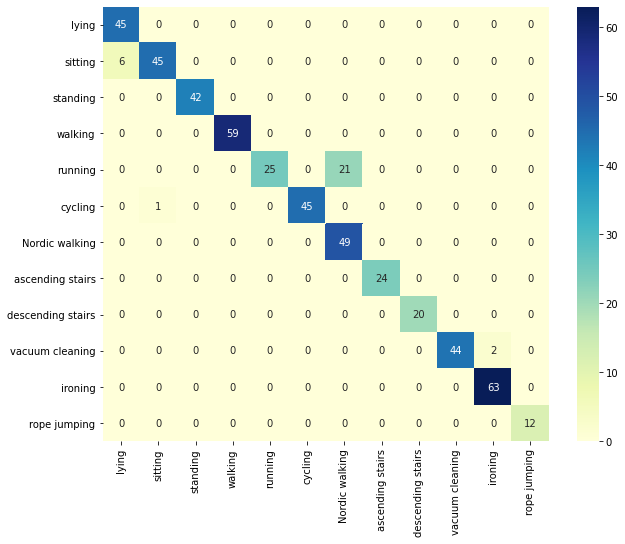

test sub ['subject106.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject102.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject106.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.2608 - accuracy: 0.5927
Epoch 2/40
49/49 - 7s - loss: 0.2436 - accuracy: 0.9332
Epoch 3/40
49/49 - 7s - loss: 0.1962 - accuracy: 0.9358
Epoch 4/40
49/49 - 7s - loss: 0.1902 - accuracy: 0.9361
Epoch 5/40
49/49 - 7s - loss: 0.0730 - accuracy: 0.9804
Epoch 6/40
49/49 - 7s - loss: 0.0474 - accuracy: 0.9897
Epoch 7/40
49/49 - 7s - loss: 0.0416 - accuracy: 0.9881
Epoch 8/40
49/49 - 7s - loss: 0.1105 - accuracy: 0.9679
Epoch 9/40
49/49 - 7s - loss: 0.1443 - accuracy: 0.9576
Epoch 10/40
49/49 - 7s - loss: 0.0788 - accuracy: 0.9762
Epoch 11/40
49/49 - 7s - loss: 0.0451 - accuracy: 0.9862
Epoch 12/40
49/49 - 7s - loss: 0.0311 - accuracy: 0.9900
Epoch 13/40
49/49 - 7s - loss: 0.0391 - accuracy: 0.9878
Epoch 14/40
49/49 - 7s - loss: 0.1096 - accuracy: 0.9711
Epoch 15/40
49/49 - 7s - loss: 0.0241 - accuracy: 0.9929
Epoch 16/40
49/49 - 7s - loss: 0.0296 - accuracy: 0.9891
Epoch 17/40
49/49 - 7s - loss: 0.0464 - accuracy: 0.9865
Epoch 18/40
49/49 - 7s - loss: 0.0

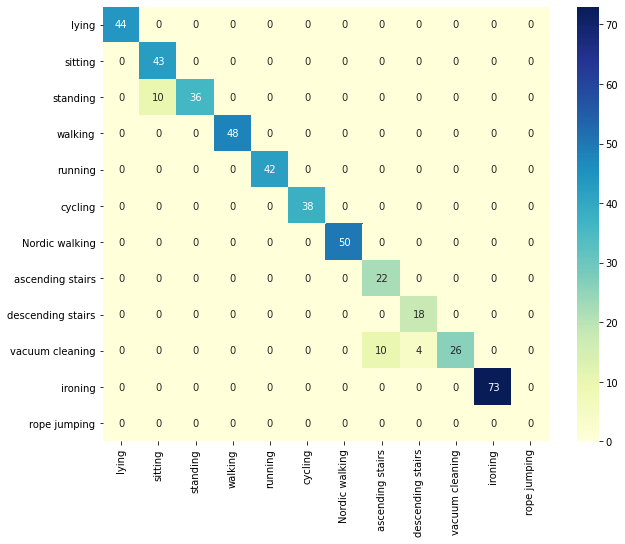

test sub ['subject107.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject107.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
50/50 - 7s - loss: 1.3365 - accuracy: 0.5521
Epoch 2/40
50/50 - 7s - loss: 0.3484 - accuracy: 0.8853
Epoch 3/40
50/50 - 7s - loss: 0.1733 - accuracy: 0.9463
Epoch 4/40
50/50 - 7s - loss: 0.1250 - accuracy: 0.9676
Epoch 5/40
50/50 - 7s - loss: 0.0740 - accuracy: 0.9806
Epoch 6/40
50/50 - 7s - loss: 0.0450 - accuracy: 0.9882
Epoch 7/40
50/50 - 7s - loss: 0.1172 - accuracy: 0.9651
Epoch 8/40
50/50 - 7s - loss: 0.0773 - accuracy: 0.9762
Epoch 9/40
50/50 - 7s - loss: 0.0578 - accuracy: 0.9813
Epoch 10/40
50/50 - 7s - loss: 0.0376 - accuracy: 0.9898
Epoch 11/40
50/50 - 7s - loss: 0.0374 - accuracy: 0.9914
Epoch 12/40
50/50 - 7s - loss: 0.0302 - accuracy: 0.9921
Epoch 13/40
50/50 - 7s - loss: 0.0160 - accuracy: 0.9956
Epoch 14/40
50/50 - 7s - loss: 0.0835 - accuracy: 0.9755
Epoch 15/40
50/50 - 7s - loss: 0.0825 - accuracy: 0.9762
Epoch 16/40
50/50 - 7s - loss: 0.0737 - accuracy: 0.9784
Epoch 17/40
50/50 - 7s - loss: 0.0461 - accuracy: 0.9882
Epoch 18/40
50/50 - 7s - loss: 0.0

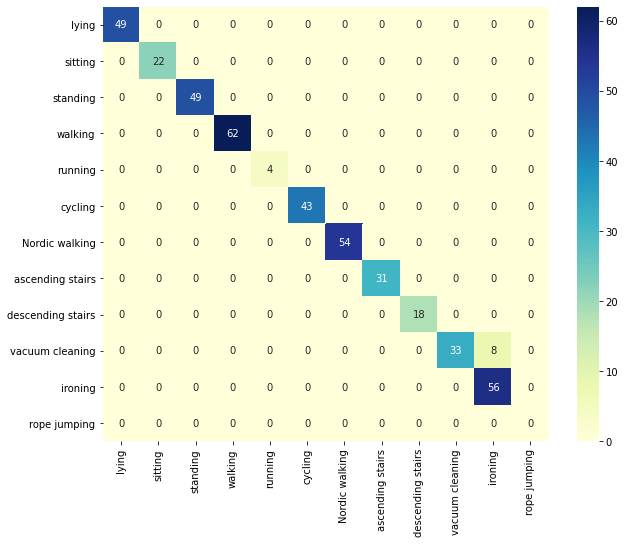

test sub ['subject108.dat']
{'train': ['subject105.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject108.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.5861 - accuracy: 0.4840
Epoch 2/40
49/49 - 7s - loss: 0.3676 - accuracy: 0.8805
Epoch 3/40
49/49 - 7s - loss: 0.1926 - accuracy: 0.9402
Epoch 4/40
49/49 - 7s - loss: 0.1561 - accuracy: 0.9538
Epoch 5/40
49/49 - 7s - loss: 0.0785 - accuracy: 0.9803
Epoch 6/40
49/49 - 7s - loss: 0.0798 - accuracy: 0.9800
Epoch 7/40
49/49 - 7s - loss: 0.1461 - accuracy: 0.9632
Epoch 8/40
49/49 - 7s - loss: 0.1155 - accuracy: 0.9677
Epoch 9/40
49/49 - 7s - loss: 0.0561 - accuracy: 0.9851
Epoch 10/40
49/49 - 7s - loss: 0.0220 - accuracy: 0.9952
Epoch 11/40
49/49 - 7s - loss: 0.0373 - accuracy: 0.9910
Epoch 12/40
49/49 - 7s - loss: 0.0209 - accuracy: 0.9955
Epoch 13/40
49/49 - 7s - loss: 0.0387 - accuracy: 0.9897
Epoch 14/40
49/49 - 7s - loss: 0.0215 - accuracy: 0.9939
Epoch 15/40
49/49 - 7s - loss: 0.0945 - accuracy: 0.9716
Epoch 16/40
49/49 - 7s - loss: 0.1540 - accuracy: 0.9586
Epoch 17/40
49/49 - 7s - loss: 0.0537 - accuracy: 0.9842
Epoch 18/40
49/49 - 7s - loss: 0.0

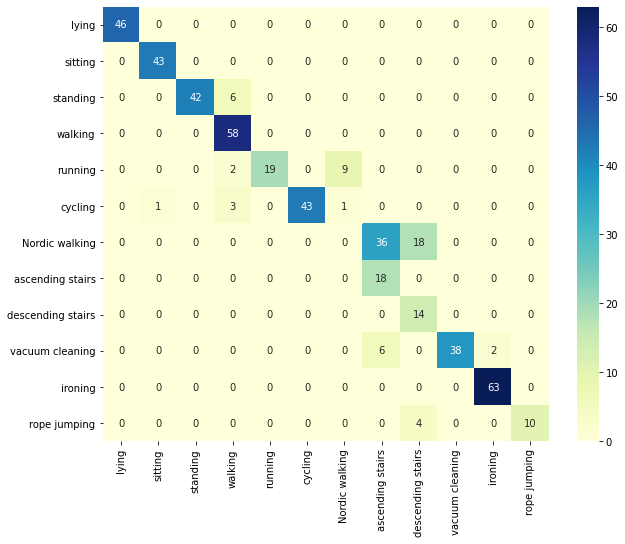

test sub ['subject109.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat'], 'test': ['subject109.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
56/56 - 8s - loss: 1.2423 - accuracy: 0.6100
Epoch 2/40
56/56 - 8s - loss: 0.3302 - accuracy: 0.8771
Epoch 3/40
56/56 - 8s - loss: 0.1782 - accuracy: 0.9467
Epoch 4/40
56/56 - 8s - loss: 0.1439 - accuracy: 0.9559
Epoch 5/40
56/56 - 8s - loss: 0.1352 - accuracy: 0.9554
Epoch 6/40
56/56 - 8s - loss: 0.0661 - accuracy: 0.9837
Epoch 7/40
56/56 - 8s - loss: 0.0945 - accuracy: 0.9717
Epoch 8/40
56/56 - 8s - loss: 0.0908 - accuracy: 0.9753
Epoch 9/40
56/56 - 8s - loss: 0.0653 - accuracy: 0.9809
Epoch 10/40
56/56 - 8s - loss: 0.1509 - accuracy: 0.9529
Epoch 11/40
56/56 - 8s - loss: 0.0634 - accuracy: 0.9812
Epoch 12/40
56/56 - 8s - loss: 0.0190 - accuracy: 0.9952
Epoch 13/40
56/56 - 8s - loss: 0.0601 - accuracy: 0.9826
Epoch 14/40
56/56 - 8s - loss: 0.0613 - accuracy: 0.9832
Epoch 15/40
56/56 - 8s - loss: 0.0609 - accuracy: 0.9815
Epoch 16/40
56/56 - 8s - loss: 0.0375 - accuracy: 0.9907
Epoch 17/40
56/56 - 8s - loss: 0.0132 - accuracy: 0.9958
Epoch 18/40
56/56 - 8s - loss: 0.0

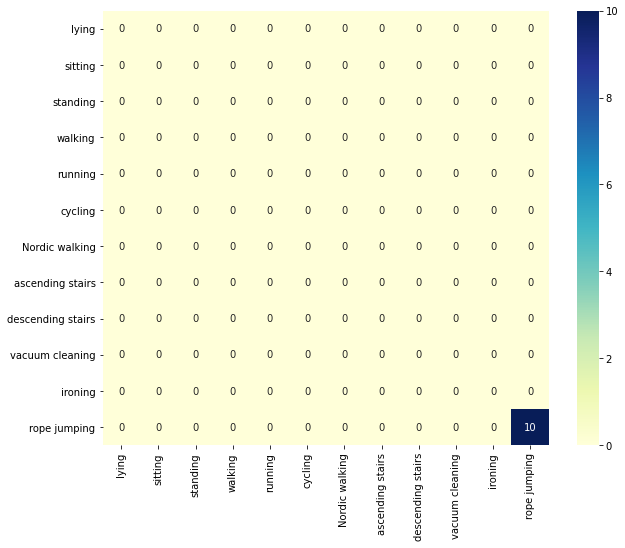

In [29]:
#with magnetometer
run_experiment()

In [1]:
!rm *.h5

test sub ['subject101.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject109.dat'], 'test': ['subject101.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.6029 - accuracy: 0.4920
Epoch 2/40
49/49 - 7s - loss: 0.3136 - accuracy: 0.8979
Epoch 3/40
49/49 - 7s - loss: 0.1726 - accuracy: 0.9413
Epoch 4/40
49/49 - 7s - loss: 0.0849 - accuracy: 0.9782
Epoch 5/40
49/49 - 7s - loss: 0.0412 - accuracy: 0.9913
Epoch 6/40
49/49 - 7s - loss: 0.0826 - accuracy: 0.9769
Epoch 7/40
49/49 - 7s - loss: 0.1534 - accuracy: 0.9544
Epoch 8/40
49/49 - 7s - loss: 0.0354 - accuracy: 0.9904
Epoch 9/40
49/49 - 7s - loss: 0.1773 - accuracy: 0.9461
Epoch 10/40
49/49 - 7s - loss: 0.0556 - accuracy: 0.9843
Epoch 11/40
49/49 - 7s - loss: 0.1200 - accuracy: 0.9650
Epoch 12/40
49/49 - 7s - loss: 0.0556 - accuracy: 0.9836
Epoch 13/40
49/49 - 7s - loss: 0.1082 - accuracy: 0.9750
Epoch 14/40
49/49 - 7s - loss: 0.0436 - accuracy: 0.9894
Epoch 15/40
49/49 - 7s - loss: 0.0185 - accuracy: 0.9945
Epoch 16/40
49/49 - 7s - loss: 0.0148 - accuracy: 0.9968
Epoch 17/40
49/49 - 7s - loss: 0.0088 - accuracy: 0.9978
Epoch 18/40
49/49 - 7s - loss: 0.0

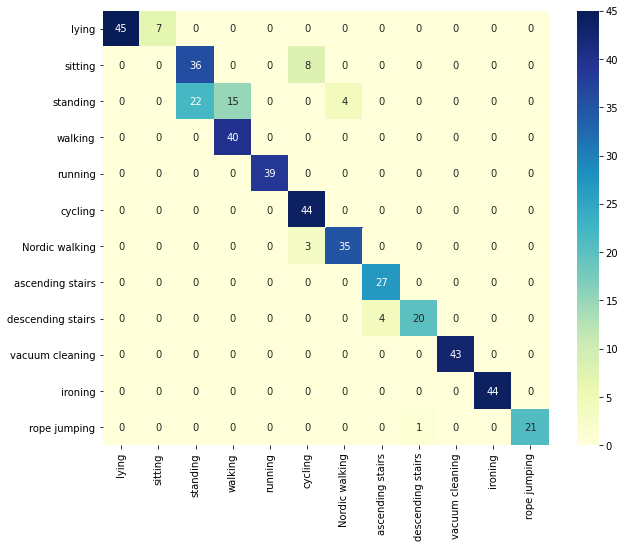

test sub ['subject102.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject102.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.3156 - accuracy: 0.5850
Epoch 2/40
49/49 - 7s - loss: 0.2305 - accuracy: 0.9360
Epoch 3/40
49/49 - 7s - loss: 0.1063 - accuracy: 0.9719
Epoch 4/40
49/49 - 7s - loss: 0.1019 - accuracy: 0.9719
Epoch 5/40
49/49 - 7s - loss: 0.0597 - accuracy: 0.9829
Epoch 6/40
49/49 - 7s - loss: 0.1017 - accuracy: 0.9741
Epoch 7/40
49/49 - 7s - loss: 0.0960 - accuracy: 0.9729
Epoch 8/40
49/49 - 7s - loss: 0.1363 - accuracy: 0.9580
Epoch 9/40
49/49 - 7s - loss: 0.0546 - accuracy: 0.9851
Epoch 10/40
49/49 - 7s - loss: 0.0330 - accuracy: 0.9913
Epoch 11/40
49/49 - 7s - loss: 0.0452 - accuracy: 0.9864
Epoch 12/40
49/49 - 7s - loss: 0.1389 - accuracy: 0.9583
Epoch 13/40
49/49 - 7s - loss: 0.1639 - accuracy: 0.9528
Epoch 14/40
49/49 - 7s - loss: 0.0693 - accuracy: 0.9816
Epoch 15/40
49/49 - 7s - loss: 0.0301 - accuracy: 0.9910
Epoch 16/40
49/49 - 7s - loss: 0.0124 - accuracy: 0.9968
Epoch 17/40
49/49 - 7s - loss: 0.0138 - accuracy: 0.9948
Epoch 18/40
49/49 - 7s - loss: 0.0

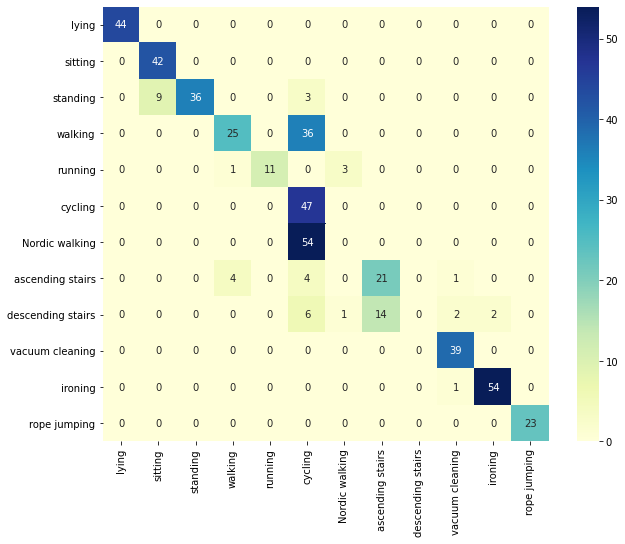

test sub ['subject103.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject103.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
51/51 - 7s - loss: 1.1662 - accuracy: 0.6346
Epoch 2/40
51/51 - 7s - loss: 0.2511 - accuracy: 0.9276
Epoch 3/40
51/51 - 7s - loss: 0.1696 - accuracy: 0.9469
Epoch 4/40
51/51 - 7s - loss: 0.0791 - accuracy: 0.9782
Epoch 5/40
51/51 - 7s - loss: 0.0986 - accuracy: 0.9718
Epoch 6/40
51/51 - 7s - loss: 0.0537 - accuracy: 0.9856
Epoch 7/40
51/51 - 7s - loss: 0.0898 - accuracy: 0.9751
Epoch 8/40
51/51 - 7s - loss: 0.0989 - accuracy: 0.9761
Epoch 9/40
51/51 - 7s - loss: 0.0999 - accuracy: 0.9718
Epoch 10/40
51/51 - 7s - loss: 0.0805 - accuracy: 0.9804
Epoch 11/40
51/51 - 7s - loss: 0.0634 - accuracy: 0.9816
Epoch 12/40
51/51 - 7s - loss: 0.0668 - accuracy: 0.9813
Epoch 13/40
51/51 - 7s - loss: 0.0340 - accuracy: 0.9896
Epoch 14/40
51/51 - 7s - loss: 0.0273 - accuracy: 0.9923
Epoch 15/40
51/51 - 7s - loss: 0.0790 - accuracy: 0.9807
Epoch 16/40
51/51 - 7s - loss: 0.0544 - accuracy: 0.9853
Epoch 17/40
51/51 - 7s - loss: 0.1150 - accuracy: 0.9672
Epoch 18/40
51/51 - 7s - loss: 0.0

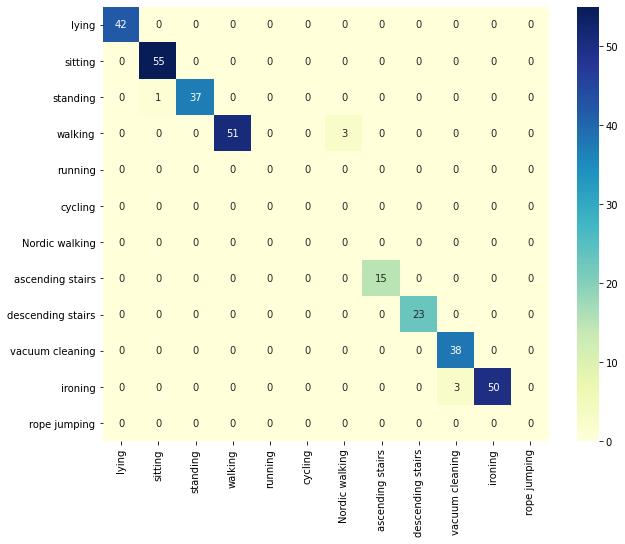

test sub ['subject104.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject104.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
50/50 - 7s - loss: 1.5851 - accuracy: 0.4927
Epoch 2/40
50/50 - 7s - loss: 0.3271 - accuracy: 0.8905
Epoch 3/40
50/50 - 7s - loss: 0.1361 - accuracy: 0.9625
Epoch 4/40
50/50 - 7s - loss: 0.1679 - accuracy: 0.9565
Epoch 5/40
50/50 - 7s - loss: 0.1388 - accuracy: 0.9597
Epoch 6/40
50/50 - 7s - loss: 0.0503 - accuracy: 0.9870
Epoch 7/40
50/50 - 7s - loss: 0.0689 - accuracy: 0.9819
Epoch 8/40
50/50 - 7s - loss: 0.1129 - accuracy: 0.9638
Epoch 9/40
50/50 - 7s - loss: 0.1066 - accuracy: 0.9632
Epoch 10/40
50/50 - 7s - loss: 0.1856 - accuracy: 0.9416
Epoch 11/40
50/50 - 7s - loss: 0.3076 - accuracy: 0.9143
Epoch 12/40
50/50 - 7s - loss: 0.0928 - accuracy: 0.9733
Epoch 13/40
50/50 - 7s - loss: 0.0522 - accuracy: 0.9844
Epoch 14/40
50/50 - 7s - loss: 0.0640 - accuracy: 0.9781
Epoch 15/40
50/50 - 7s - loss: 0.0288 - accuracy: 0.9924
Epoch 16/40
50/50 - 7s - loss: 0.0317 - accuracy: 0.9924
Epoch 17/40
50/50 - 7s - loss: 0.0253 - accuracy: 0.9943
Epoch 18/40
50/50 - 7s - loss: 0.0

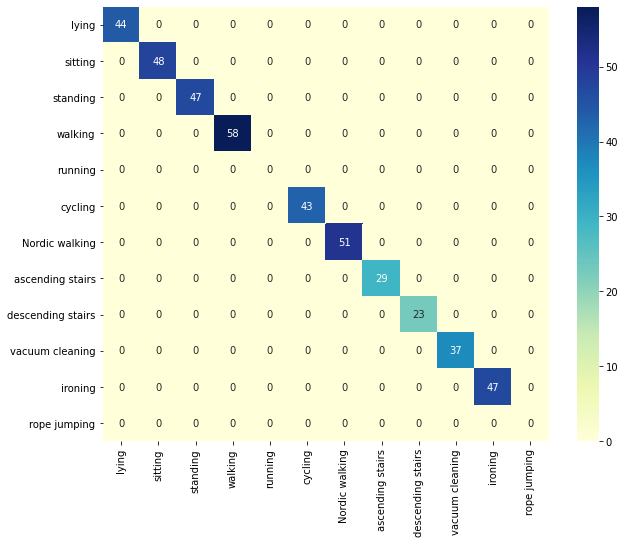

test sub ['subject105.dat']
{'train': ['subject108.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject105.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.5555 - accuracy: 0.4993
Epoch 2/40
49/49 - 7s - loss: 0.4024 - accuracy: 0.8787
Epoch 3/40
49/49 - 7s - loss: 0.1744 - accuracy: 0.9535
Epoch 4/40
49/49 - 7s - loss: 0.2154 - accuracy: 0.9317
Epoch 5/40
49/49 - 7s - loss: 0.0629 - accuracy: 0.9860
Epoch 6/40
49/49 - 7s - loss: 0.0831 - accuracy: 0.9763
Epoch 7/40
49/49 - 7s - loss: 0.0287 - accuracy: 0.9951
Epoch 8/40
49/49 - 7s - loss: 0.0297 - accuracy: 0.9938
Epoch 9/40
49/49 - 7s - loss: 0.0309 - accuracy: 0.9919
Epoch 10/40
49/49 - 7s - loss: 0.1245 - accuracy: 0.9632
Epoch 11/40
49/49 - 7s - loss: 0.4053 - accuracy: 0.8897
Epoch 12/40
49/49 - 7s - loss: 0.0905 - accuracy: 0.9723
Epoch 13/40
49/49 - 7s - loss: 0.0459 - accuracy: 0.9876
Epoch 14/40
49/49 - 7s - loss: 0.1037 - accuracy: 0.9714
Epoch 15/40
49/49 - 7s - loss: 0.0597 - accuracy: 0.9876
Epoch 16/40
49/49 - 7s - loss: 0.0772 - accuracy: 0.9789
Epoch 17/40
49/49 - 7s - loss: 0.0219 - accuracy: 0.9941
Epoch 18/40
49/49 - 7s - loss: 0.0

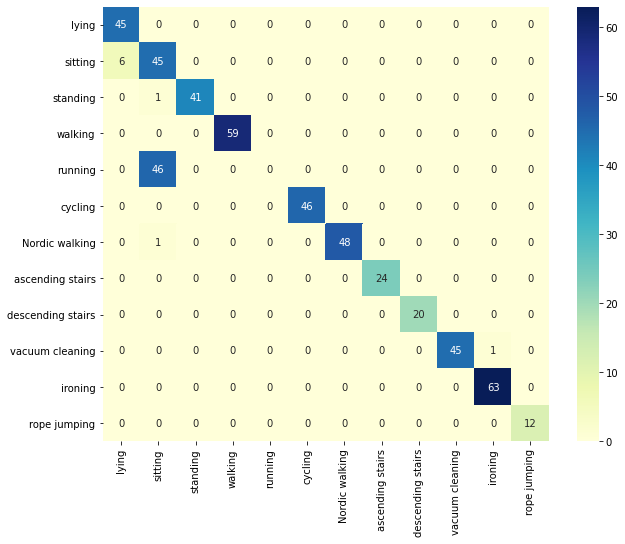

test sub ['subject106.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject102.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject106.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.9399 - accuracy: 0.3620
Epoch 2/40
49/49 - 7s - loss: 0.6418 - accuracy: 0.7748
Epoch 3/40
49/49 - 7s - loss: 0.2734 - accuracy: 0.9081
Epoch 4/40
49/49 - 7s - loss: 0.3372 - accuracy: 0.8885
Epoch 5/40
49/49 - 7s - loss: 0.1873 - accuracy: 0.9399
Epoch 6/40
49/49 - 7s - loss: 0.0801 - accuracy: 0.9765
Epoch 7/40
49/49 - 7s - loss: 0.0494 - accuracy: 0.9862
Epoch 8/40
49/49 - 7s - loss: 0.0711 - accuracy: 0.9807
Epoch 9/40
49/49 - 7s - loss: 0.0306 - accuracy: 0.9920
Epoch 10/40
49/49 - 7s - loss: 0.0443 - accuracy: 0.9897
Epoch 11/40
49/49 - 7s - loss: 0.1857 - accuracy: 0.9438
Epoch 12/40
49/49 - 7s - loss: 0.0924 - accuracy: 0.9724
Epoch 13/40
49/49 - 7s - loss: 0.1361 - accuracy: 0.9608
Epoch 14/40
49/49 - 7s - loss: 0.1035 - accuracy: 0.9701
Epoch 15/40
49/49 - 7s - loss: 0.0395 - accuracy: 0.9891
Epoch 16/40
49/49 - 7s - loss: 0.0225 - accuracy: 0.9949
Epoch 17/40
49/49 - 7s - loss: 0.0485 - accuracy: 0.9843
Epoch 18/40
49/49 - 7s - loss: 0.0

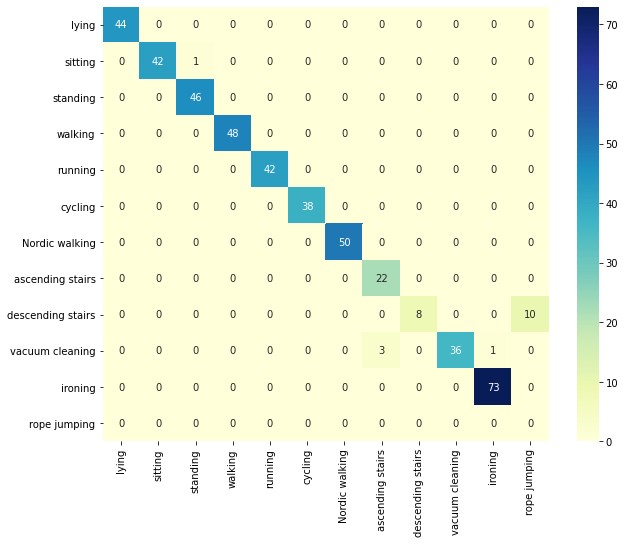

test sub ['subject107.dat']
{'train': ['subject105.dat', 'subject108.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject107.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
50/50 - 7s - loss: 1.7435 - accuracy: 0.3841
Epoch 2/40
50/50 - 7s - loss: 0.5367 - accuracy: 0.7875
Epoch 3/40
50/50 - 7s - loss: 0.2145 - accuracy: 0.9358
Epoch 4/40
50/50 - 7s - loss: 0.2321 - accuracy: 0.9257
Epoch 5/40
50/50 - 7s - loss: 0.1079 - accuracy: 0.9695
Epoch 6/40
50/50 - 7s - loss: 0.0624 - accuracy: 0.9832
Epoch 7/40
50/50 - 7s - loss: 0.0477 - accuracy: 0.9870
Epoch 8/40
50/50 - 7s - loss: 0.0319 - accuracy: 0.9917
Epoch 9/40
50/50 - 7s - loss: 0.0686 - accuracy: 0.9822
Epoch 10/40
50/50 - 7s - loss: 0.0824 - accuracy: 0.9743
Epoch 11/40
50/50 - 7s - loss: 0.0723 - accuracy: 0.9762
Epoch 12/40
50/50 - 7s - loss: 0.0617 - accuracy: 0.9838
Epoch 13/40
50/50 - 7s - loss: 0.0710 - accuracy: 0.9755
Epoch 14/40
50/50 - 7s - loss: 0.0706 - accuracy: 0.9822
Epoch 15/40
50/50 - 7s - loss: 0.0393 - accuracy: 0.9889
Epoch 16/40
50/50 - 7s - loss: 0.0188 - accuracy: 0.9952
Epoch 17/40
50/50 - 7s - loss: 0.0479 - accuracy: 0.9838
Epoch 18/40
50/50 - 7s - loss: 0.1

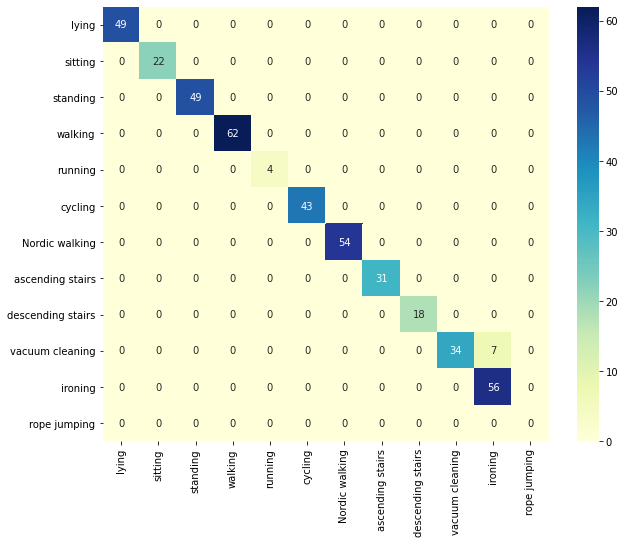

test sub ['subject108.dat']
{'train': ['subject105.dat', 'subject103.dat', 'subject102.dat', 'subject106.dat', 'subject104.dat', 'subject107.dat', 'subject101.dat', 'subject109.dat'], 'test': ['subject108.dat'], 'validation': []}
Reading pamap2
Reading file 1 of 8
Reading file 2 of 8
Reading file 3 of 8
Reading file 4 of 8
Reading file 5 of 8
Reading file 6 of 8
Reading file 7 of 8
Reading file 8 of 8
Reading file 1 of 1


<ipython-input-2-f78ba2b4fb70>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(output_file_name)


Done.
Epoch 1/40
49/49 - 7s - loss: 1.6653 - accuracy: 0.4420
Epoch 2/40


In [ ]:
#with magnetometer
run_experiment()

### Explainability

In [ ]:
def plot_single_window(window, modality=1, label=None):
    sensors= ['handacc1','handacc2','handacc3','handgyro1','handgyro2','handgyro3',
 'chestacc1','chestacc2','chestacc3','chestgyro1','chestgyro2','chestgyro3',
 'ankleacc1','ankleacc2','ankleacc3','anklegyro1','anklegyro2','anklegyro3']
    v = pd.DataFrame(window)
    v.columns = sensors

    # if modality == 1:
    #     v.drop(columns=sensors[6:], inplace=True)
    # elif modality == 2:
    #     v.drop(columns=sensors[:6], inplace=True)
    #     v.drop(columns=sensors[12:], inplace=True)
    # elif modality == 3:
    #     v.drop(columns=sensors[:12], inplace=True)

    # print(v)
    # v.columns = ['handacc1', 'handgyro1', 'chestacc1', 'chestgyro1', 'ankleacc1', 'anklegyro1']
    if label is not None:
        print('class: ', label)
    
    v.plot()

    # plt.title('Activity : Walking')
    # plt.set_axis_bgcolor('white')
    plt.xlabel('Sample index')
    plt.ylabel('Sensor reading')
    plt.figure(figsize=(35,15))

    plt.show()

In [51]:
window_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("multi_window_encoder").output)
session_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("combined_sensor_self_attention_1").output)

In [52]:
_, w_out = window_model.predict(X_test)
_, s_out = session_model.predict(X_test)

In [56]:
w_out.shape

(468, 45, 100)

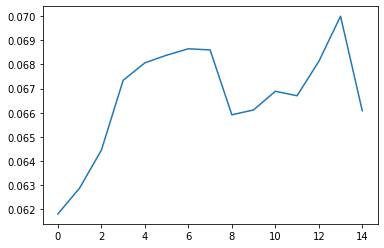

In [54]:
plt.plot(s_out[111].flatten())

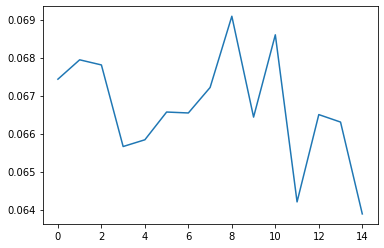

In [55]:
plt.plot(s_out[112].flatten())

In [57]:
w_out[11].shape

(45, 100)

Activity:  sitting
Prediction:  lying 



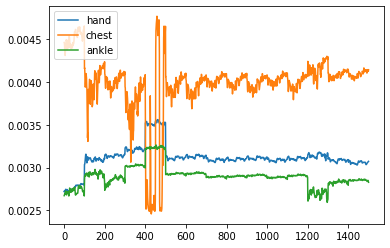

In [60]:
idx = 81
print('Activity: ', class_names[np.argmax(y_test[idx])])
print('Prediction: ',class_names[np.argmax(pred[idx])], '\n')
aa1 = w_out[idx].flatten()
plt.plot(w_out[idx,0::3, :].flatten(), label='hand')
plt.plot(w_out[idx,1::3,:].flatten(), label='chest')
plt.plot(w_out[idx,2::3, :].flatten(),label='ankle')
plt.legend(loc="upper left")
plt.show()

Activity:  standing
Prediction:  sitting 



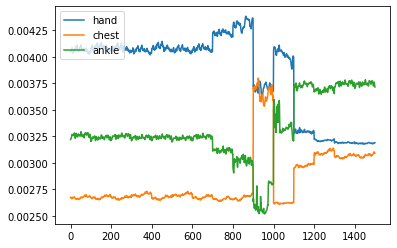

In [61]:
idx = 101
print('Activity: ', class_names[np.argmax(y_test[idx])])
print('Prediction: ',class_names[np.argmax(pred[idx])], '\n')
aa1 = w_out[idx].flatten()
plt.plot(w_out[idx,0::3, :].flatten(), label='hand')
plt.plot(w_out[idx,1::3,:].flatten(), label='chest')
plt.plot(w_out[idx,2::3, :].flatten(),label='ankle')
plt.legend(loc="upper left")
plt.show()

Activity:  lying
Prediction:  lying 



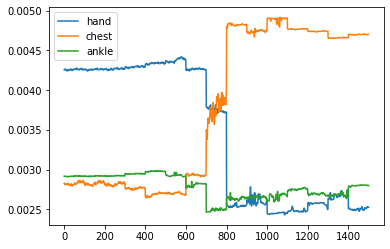

Activity:  lying
Prediction:  lying 



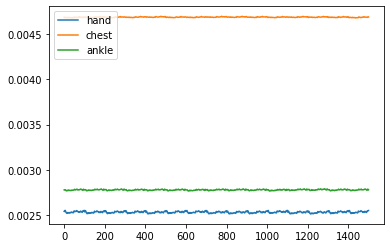

Activity:  lying
Prediction:  lying 



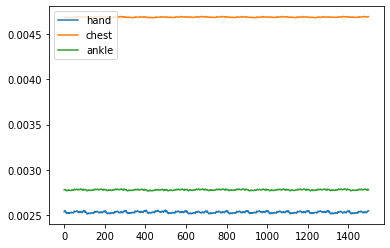

Activity:  sitting
Prediction:  sitting 



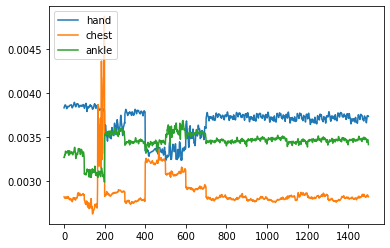

Activity:  sitting
Prediction:  lying 



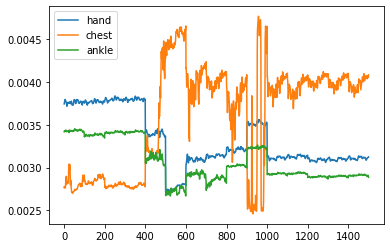

Activity:  standing
Prediction:  sitting 



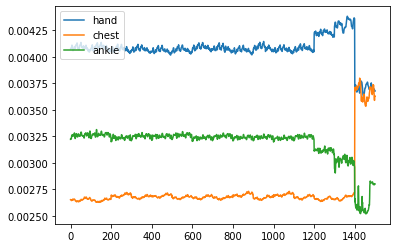

Activity:  standing
Prediction:  standing 



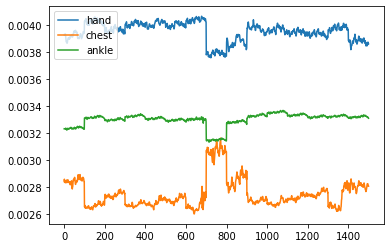

Activity:  ironing
Prediction:  ironing 



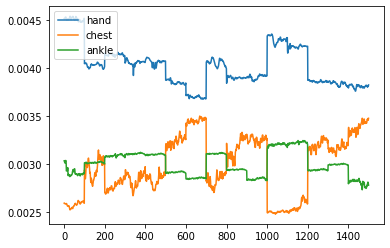

Activity:  ironing
Prediction:  ironing 



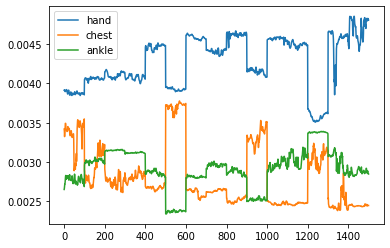

Activity:  ironing
Prediction:  ironing 



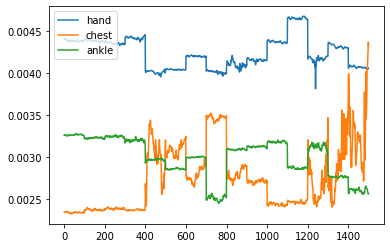

Activity:  ironing
Prediction:  ironing 



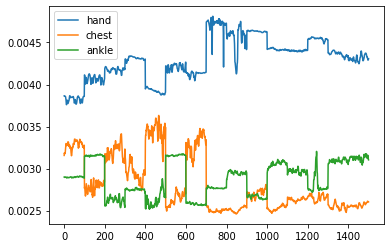

Activity:  vacuum cleaning
Prediction:  vacuum cleaning 



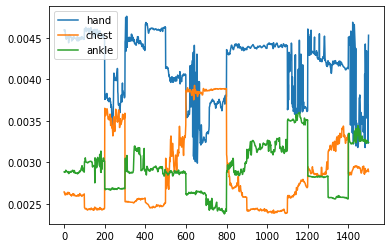

Activity:  vacuum cleaning
Prediction:  vacuum cleaning 



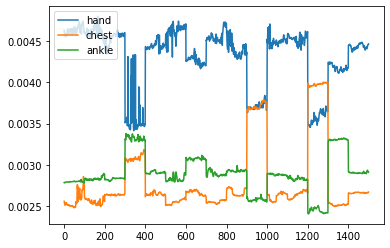

Activity:  descending stairs
Prediction:  descending stairs 



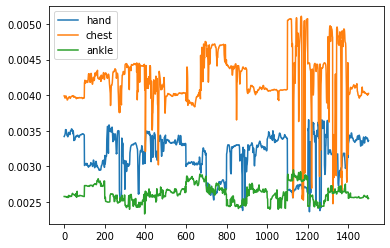

Activity:  descending stairs
Prediction:  descending stairs 



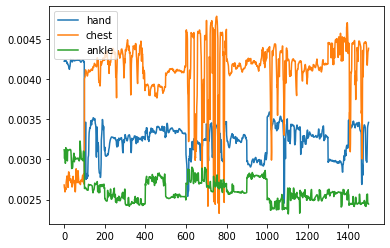

Activity:  walking
Prediction:  walking 



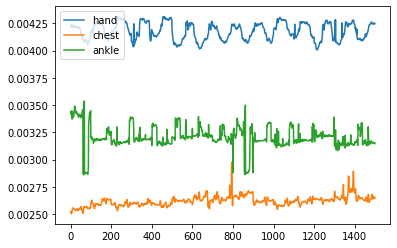

Activity:  walking
Prediction:  walking 



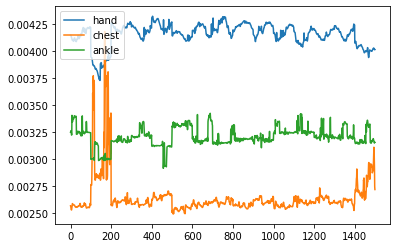

Activity:  Nordic walking
Prediction:  Nordic walking 



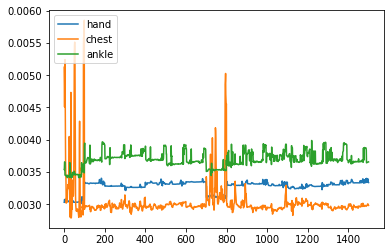

Activity:  Nordic walking
Prediction:  Nordic walking 



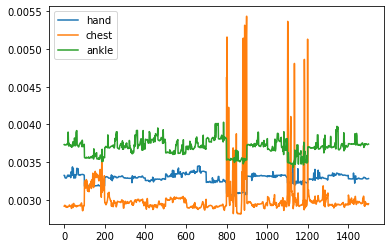

Activity:  Nordic walking
Prediction:  Nordic walking 



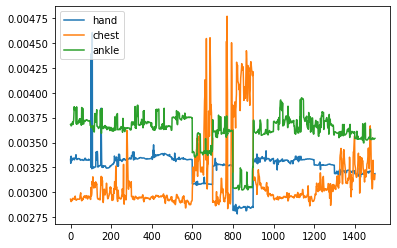

Activity:  cycling
Prediction:  cycling 



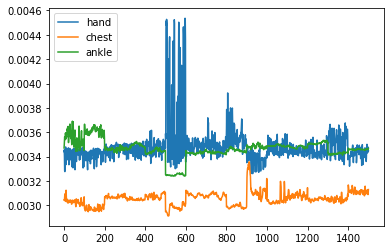

Activity:  cycling
Prediction:  cycling 



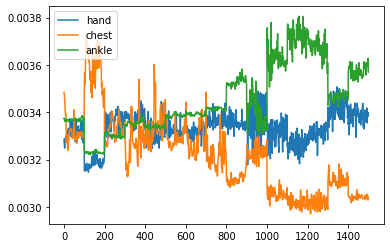

Activity:  running
Prediction:  running 



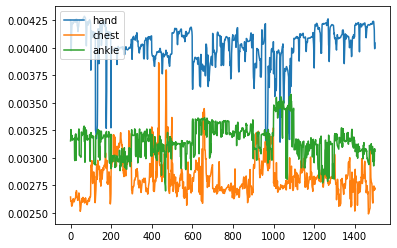

Activity:  running
Prediction:  running 



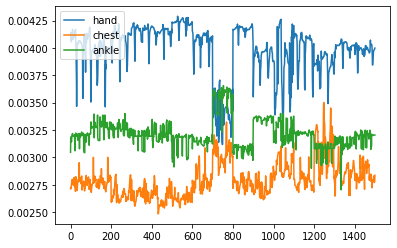

In [64]:
for idx in range(0, 480, 20):
    print('Activity: ', class_names[np.argmax(y_test[idx])])
    print('Prediction: ',class_names[np.argmax(pred[idx])], '\n')
    aa1 = w_out[idx].flatten()
    plt.plot(w_out[idx,0::3, :].flatten(), label='hand')
    plt.plot(w_out[idx,1::3,:].flatten(), label='chest')
    plt.plot(w_out[idx,2::3, :].flatten(),label='ankle')
    plt.legend(loc="upper left")
    plt.show()